#**LABORATORIO 2 - MLP PYTORCH**

Nombre: Gonzales Suyo Franz Reinaldo

Dirección de GitHub:

##*LABORATORIO 2*

###Construir un MLP, con pytorch, considerando lo siguiente:

- El MLP, debe servir para realizar clasificaciones de al menos 5 clases o tipos de difentes ambitos.

- El MLP debe contener al menos 50 unidades  neuronales en una capa oculta.

- Se debe entrenar por almenos 1000 epochs y explicar que sucede en este proceso.

- Se debe implementar un mecanismo de checkpoints para el proceso de entrenamiento que permita respaldar los valores calculados para los parametros, cada 20 epochs.

- Aplicar las formas (frameworks) de exportación de modelos Torchscript y ONNX, a traves de ejemplos.

- Utilizar de manera obligatoria objetos dataset y dataloader en la implementacion.

- Se debe aplicar las tecnicas de normalizacion, optimizacion y buenas practicas para lograr el menor valor de costo y el mayor valor de precision.


Se debe subir todo a un repositorio el cual debes ser compartido, ademas de subir todos los cuadernillos o codigo fuente generados.

In [ ]:
# IMPORTAMOS LAS LIBRERIAS

import torch
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import random


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**MODELO DE RED NEURONAL - SECUENCIAL**

In [ ]:
# CARGAR LOS DATASET

# CARGAMOS LOS DATASET DE ENTRENAMIENTO Y PRUEBA

import torch
from torch.utils.data import Dataset, DataLoader

class PlantasDataset(Dataset):
    def __init__(self, archivo_dataset):
        self.imagenes, self.etiquetas = torch.load(archivo_dataset)

    def __len__(self):
        return len(self.etiquetas)

    def __getitem__(self, idx):
        return self.imagenes[idx], self.etiquetas[idx]

# Cargar datasets
trainset = PlantasDataset('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_train.pt')
testset = PlantasDataset('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_test.pt')


print("Número de ejemplos en el conjunto de entrenamiento:", len(trainset))
print("Número de ejemplos en el conjunto de prueba:", len(testset))


Número de ejemplos en el conjunto de entrenamiento: 60000
Número de ejemplos en el conjunto de prueba: 15000


In [ ]:
# Extraer imágenes y etiquetas del conjunto de entrenamiento
X_train = torch.stack([trainset[i][0] for i in range(len(trainset))])
y_train = torch.tensor([trainset[i][1] for i in range(len(trainset))])

# Extraer imágenes y etiquetas del conjunto de prueba
X_test = torch.stack([testset[i][0] for i in range(len(testset))])
y_test = torch.tensor([testset[i][1] for i in range(len(testset))])

# Normalizar los datos (opcional, dependiendo de tus necesidades)
X_train = X_train.float() / 255.0  # Normalización de las imágenes de entrenamiento
X_test = X_test.float() / 255.0    # Normalización de las imágenes de prueba

# Enviar los tensores a la GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Imprimir tamaños para verificar
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de y_test:", y_test.shape)


Tamaño de X_train: torch.Size([60000, 3, 50, 50])
Tamaño de y_train: torch.Size([60000])
Tamaño de X_test: torch.Size([15000, 3, 50, 50])
Tamaño de y_test: torch.Size([15000])


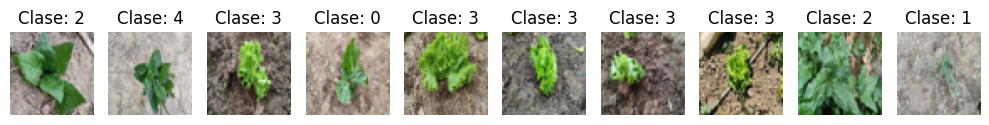

In [ ]:
import matplotlib.pyplot as plt

# Número de imágenes a mostrar
num_images_to_show = 10

# Seleccionar aleatoriamente algunas imágenes para mostrar
indices = torch.randint(0, len(X_train), (num_images_to_show,))

# Configurar la visualización
plt.figure(figsize=(10, 5))

for i, idx in enumerate(indices):
    # Seleccionar la imagen y la etiqueta
    img = X_train[idx].cpu().numpy()  # Convertir a numpy para matplotlib
    label = y_train[idx].cpu().item()  # Obtener la etiqueta como un número

    # Si las imágenes son en escala de grises, eliminar la dimensión del canal
    if img.shape[0] == 1:
        img = img.squeeze(0)

    # Si las imágenes tienen 3 canales (RGB), convertir de CHW a HWC para matplotlib
    elif img.shape[0] == 3:
        img = img.transpose(1, 2, 0)

    # Mostrar la imagen
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img, cmap='gray') if img.ndim == 2 else plt.imshow(img)
    plt.title(f'Clase: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

def softmax(x):
    # Calcula la función softmax sobre las predicciones del modelo
    return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)

def evaluate(x):
    # Cambia el modelo a modo de evaluación
    model.eval()
    # Realiza la predicción con el modelo para la entrada dada
    y_pred = model(x)
    # Calcula las probabilidades de clase usando softmax
    y_probas = softmax(y_pred)
    # Devuelve la clase con la mayor probabilidad
    return torch.argmax(y_probas, axis=1)


In [ ]:
# Definir las dimensiones de entrada, la cantidad de neuronas en la capa oculta y la salida

# Crear el modelo secuencial
D_in, H1, H2, D_out = 50*50*3, 100, 50, 5

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),  # Dropout con una probabilidad de 0.5
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out),
) #.to("cuda")                  # Mover el modelo a la GPU

# Definir la función de pérdida y el optimizador
criterion = torch.nn.CrossEntropyLoss()    # Pérdida para clasificación múltiple
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


epochs = 200                     # Número total de épocas de entrenamiento
log_each = 10                    # Frecuencia de registro de pérdida
l = []                           # Lista para almacenar la pérdida

# Entrenamiento del modelo
model.train()                     # Configurar el modelo en modo de entrenamiento
for e in range(1, epochs+1):

    # Forward pass: calcular predicciones
    y_pred = model(X_train)

    # Calcular la pérdida
    loss = criterion(y_pred, y_train)
    l.append(loss.item())        # Guardar la pérdida en la lista

    # Poner a cero los gradientes acumulados
    optimizer.zero_grad()

    # Backward pass: calcular gradientes
    loss.backward()

    # Actualizar los pesos del modelo
    optimizer.step()

    # Registrar la pérdida en intervalos definidos
    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")



Epoch 10/200 Loss 1.64878
Epoch 20/200 Loss 1.58959
Epoch 30/200 Loss 1.53002
Epoch 40/200 Loss 1.47268
Epoch 50/200 Loss 1.41695
Epoch 60/200 Loss 1.36461
Epoch 70/200 Loss 1.31686
Epoch 80/200 Loss 1.27318
Epoch 90/200 Loss 1.23332
Epoch 100/200 Loss 1.19697
Epoch 110/200 Loss 1.16359
Epoch 120/200 Loss 1.13374
Epoch 130/200 Loss 1.10592
Epoch 140/200 Loss 1.08023
Epoch 150/200 Loss 1.05696
Epoch 160/200 Loss 1.03546
Epoch 170/200 Loss 1.01528
Epoch 180/200 Loss 0.99631
Epoch 190/200 Loss 0.97878
Epoch 200/200 Loss 0.96241


##Iterando por Batches

En la implementación anterior estamos optimizando nuestro modelo con el algoritmo de batch gradient descent, en el que utilizamos todos nuestros datos en cada paso de optimización. Sin embargo, un algoritmo que puede converger más rápido (y única opción si nuestro dataset es tan grande que no cabe en memoria) es el de mini-batch gradient descent (el cual hemos ya utilizado en posts anteriores).

In [ ]:
import torch
import numpy as np

# Definir las dimensiones de entrada, las neuronas en las capas ocultas y la salida
D_in, H1, H2, D_out = 50*50*3, 100, 50, 5

# Crear el modelo secuencial mejorado
model = torch.nn.Sequential(
    torch.nn.Flatten(),           # Aplanar la imagen de entrada
    torch.nn.Linear(D_in, H1),    # Capa completamente conectada de entrada a la primera capa oculta
    torch.nn.BatchNorm1d(H1),     # Normalización por lotes
    torch.nn.ReLU(),              # Función de activación ReLU
    torch.nn.Dropout(0.5),        # Regularización por dropout con probabilidad 0.5
    torch.nn.Linear(H1, H2),      # Capa completamente conectada de la primera a la segunda capa oculta
    torch.nn.BatchNorm1d(H2),     # Normalización por lotes
    torch.nn.ReLU(),              # Función de activación ReLU
    torch.nn.Linear(H2, D_out)    # Capa completamente conectada de la segunda capa oculta a la salida
)#.to("cuda")                     # Mover el modelo a la GPU

# Definir la función de pérdida y el optimizador
criterion = torch.nn.CrossEntropyLoss()  # Pérdida de entropía cruzada para clasificación múltiple
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Optimizador Adam con weight decay

epochs = 100          # Número total de épocas de entrenamiento
batch_size = 100      # Tamaño de lote para entrenamiento por mini-lotes
log_each = 10         # Frecuencia de registro de pérdida
l = []                # Lista para almacenar la pérdida
batches = len(X_train) // batch_size  # Número de batches por época

# Entrenamiento del modelo
model.train()  # Configurar el modelo en modo de entrenamiento

for e in range(1, epochs+1):
    _l = []  # Lista para almacenar la pérdida por cada mini-lote
    # Iteramos por mini-lotes
    for b in range(batches):
        x_b = X_train[b*batch_size:(b+1)*batch_size]
        y_b = y_train[b*batch_size:(b+1)*batch_size]

        # Forward pass: calcular predicciones
        y_pred = model(x_b)

        # Calcular la pérdida
        loss = criterion(y_pred, y_b)
        _l.append(loss.item())  # Guardar la pérdida del mini-lote

        # Poner a cero los gradientes acumulados
        optimizer.zero_grad()

        # Backward pass: calcular gradientes
        loss.backward()

        # Actualizar los pesos del modelo
        optimizer.step()

    l.append(np.mean(_l))  # Guardar la pérdida media de la época
    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

# Imprimir resultados finales
print("Entrenamiento completado.")


Epoch 10/100 Loss 0.25913
Epoch 20/100 Loss 0.16772
Epoch 30/100 Loss 0.12838
Epoch 40/100 Loss 0.10608
Epoch 50/100 Loss 0.09133
Epoch 60/100 Loss 0.08082
Epoch 70/100 Loss 0.07303
Epoch 80/100 Loss 0.06694
Epoch 90/100 Loss 0.06203
Epoch 100/100 Loss 0.05797
Entrenamiento completado.


In [ ]:
# Asegúrate de que el modelo esté en modo de evaluación
model.eval()

# Mover X_test a la GPU si está disponible, ya que es un Tensor
X_test_tensor = X_test.cuda() if torch.cuda.is_available() else X_test

# Realizar la evaluación utilizando la función evaluate
with torch.no_grad():  # Desactiva el cálculo de gradientes para la evaluación
    y_pred = evaluate(X_test_tensor)

# Convertir las predicciones a NumPy para calcular la precisión
y_pred_numpy = y_pred.cpu().numpy() if y_pred.is_cuda else y_pred.numpy()
y_test_numpy = y_test.cpu().numpy() if y_test.is_cuda else y_test.numpy()

# Calcular la precisión usando accuracy_score
accuracy = accuracy_score(y_test_numpy, y_pred_numpy)
print(f"Precisión del modelo: {accuracy:.4f}")

Precisión del modelo: 0.9716


Si bien esta implementación es correcta y funcional, dependiendo de nuestros datos puede llegar a complicarse mucho (por ejemplo, si necesitamos cargar muchas imágenes a las cuales queremos aplicar transformaciones, juntar en batches, etc...). Además, es común reutilizar la lógica para cargar nuestros datos no sólo para entrenar la red, si no para generar predicciones. Este hecho motiva el uso de las clases especiales que Pytorch nos ofrece para ello.

##LA CLASE DATASET

In [ ]:
class DatasetPersonalizado(torch.utils.data.Dataset):
    # constructor
    def __init__(self, X, Y):
        # Asignamos los tensores directamente, ya que no son np.ndarray
        self.X = X.float()  # Convertimos a float si es necesario
        self.Y = Y.long()   # Convertimos a long si es necesario

    # devolvemos el número de datos en el dataset
    def __len__(self):
        return len(self.X)

    # devolvemos el elemento `ix` del dataset
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]



In [ ]:
# Crear el dataset personalizado
dataset = DatasetPersonalizado(X_train, y_train)

# Verificar la longitud del dataset
print(len(dataset))

60000


In [ ]:

# Definir dimensiones
D_in, H1, H2, D_out = 50*50*3, 100, 50, 5

# Crear el modelo mejorado
model = torch.nn.Sequential(
    torch.nn.Flatten(), # Add a flattening layer
    torch.nn.Linear(D_in, H1),  # Capa oculta 1
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),  # Regularización
    torch.nn.Linear(H1, H2),  # Capa oculta 2
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out),  # Capa de salida
)#.to("cuda")

# Definir la función de pérdida y el optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Parámetros de entrenamiento
epochs = 20
batch_size = 64
log_each = 1
l = []

# Configurar el modelo en modo de entrenamiento
model.train()
batches = len(X_train) // batch_size

# Entrenamiento
for e in range(1, epochs + 1):
    _l = []
    # iteramos por batches
    for b in range(batches):
        x_b = X_train[b * batch_size:(b + 1) * batch_size]
        y_b = y_train[b * batch_size:(b + 1) * batch_size]

        # Forward pass
        y_pred = model(x_b)

        # Calcular pérdida
        loss = criterion(y_pred, y_b)
        _l.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Registrar la pérdida promedio por época
    l.append(np.mean(_l))
    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")


Epoch 1/20 Loss 1.04016
Epoch 2/20 Loss 0.86414
Epoch 3/20 Loss 0.76460
Epoch 4/20 Loss 0.69523
Epoch 5/20 Loss 0.64147
Epoch 6/20 Loss 0.59853
Epoch 7/20 Loss 0.56304
Epoch 8/20 Loss 0.53224
Epoch 9/20 Loss 0.50589
Epoch 10/20 Loss 0.48312
Epoch 11/20 Loss 0.46255
Epoch 12/20 Loss 0.44408
Epoch 13/20 Loss 0.42782
Epoch 14/20 Loss 0.41289
Epoch 15/20 Loss 0.39930
Epoch 16/20 Loss 0.38682
Epoch 17/20 Loss 0.37516
Epoch 18/20 Loss 0.36465
Epoch 19/20 Loss 0.35480
Epoch 20/20 Loss 0.34568


In [ ]:
# Asegúrate de que el modelo esté en modo de evaluación
model.eval()

# Mover X_test a la GPU si está disponible, ya que es un Tensor
X_test_tensor = X_test.cuda() if torch.cuda.is_available() else X_test

# Realizar la evaluación utilizando la función evaluate
with torch.no_grad():
    y_pred = evaluate(X_test_tensor)

# Convertir las predicciones a NumPy para calcular la precisión
y_pred_numpy = y_pred.cpu().numpy() if y_pred.is_cuda else y_pred.numpy()
y_test_numpy = y_test.cpu().numpy() if y_test.is_cuda else y_test.numpy()

# Calcular la precisión usando accuracy_score
accuracy = accuracy_score(y_test_numpy, y_pred_numpy)
print(f"Precisión del modelo: {accuracy:.4f}")

Precisión del modelo: 0.9657


Podemos iterar directamente sobre el objeto dataset de la misma manera que hacíamos anteriormente, sin embargo Pytorch no ofrece otro objeto que nos facilita las cosas a la hora de iterar por batches.

##La clase DataLoader

La clase DataLoader recibe un Dataset e implementa la lógica para iterar nuestros datos en batches.

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=62, shuffle=True)

In [ ]:
x, y = next(iter(dataloader))

x.shape, y.shape

(torch.Size([62, 3, 50, 50]), torch.Size([62]))

In [ ]:
D_in, H1, H2, D_out = 50*50*3, 100, 50, 5

# Crear el modelo mejorado
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(D_in, H1),  # Primera capa oculta
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),  # Regularización con Dropout
    torch.nn.Linear(H1, H2),  # Segunda capa oculta
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out)  # Capa de salida
)#.to("cuda")  # Mover el modelo a la GPU

# Definir la función de pérdida y el optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 20
log_each = 1
l = []
model.train()
for e in range(1, epochs+1):

    _l = []
    # iteramos por batches en el dataloader
    for x_b, y_b in dataloader:

        # forward
        y_pred = model(x_b)

        # loss
        loss = criterion(y_pred, y_b)
        _l.append(loss.item())

        # ponemos a cero los gradientes
        optimizer.zero_grad()

        # Backprop (calculamos todos los gradientes automáticamente)
        loss.backward()

        # update de los pesos
        optimizer.step()

    l.append(np.mean(_l))
    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

# y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
# accuracy_score(y_test, y_pred.cpu().numpy())

Epoch 1/20 Loss 0.98735
Epoch 2/20 Loss 0.91115
Epoch 3/20 Loss 0.84848
Epoch 4/20 Loss 0.80126
Epoch 5/20 Loss 0.76541
Epoch 6/20 Loss 0.73440
Epoch 7/20 Loss 0.71090
Epoch 8/20 Loss 0.69081
Epoch 9/20 Loss 0.67367
Epoch 10/20 Loss 0.65976
Epoch 11/20 Loss 0.64756
Epoch 12/20 Loss 0.63732
Epoch 13/20 Loss 0.62760
Epoch 14/20 Loss 0.61983
Epoch 15/20 Loss 0.61551
Epoch 16/20 Loss 0.60863
Epoch 17/20 Loss 0.60186
Epoch 18/20 Loss 0.59610
Epoch 19/20 Loss 0.59069
Epoch 20/20 Loss 0.58497


In [ ]:
# Evaluación del modelo
model.eval()  # Cambiar a modo de evaluación

if isinstance(X_test, torch.Tensor):
    X_test = X_test.numpy()
X_test_tensor = torch.from_numpy(X_test).float()#.cuda()
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Calcular precisión
y_pred_numpy = y_pred.cpu().numpy()
accuracy = accuracy_score(y_test, np.argmax(y_pred_numpy, axis=1))
print(f"Precisión del modelo: {accuracy:.4f}")

Precisión del modelo: 0.7245


In [ ]:
# También permite definir nuestra propia lógica para crear los batches, algo que puede ser útil en ciertas ocasiones.

def collate_fn(batch):
    return torch.stack([x for x, y in batch]), torch.stack([y for x, y in batch])
    # , torch.stack([2.*x for x, y in batch])

También permite definir nuestra propia lógica para crear los batches, algo que puede ser útil en ciertas ocasiones.

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np

# Definir dimensiones de entrada, capas ocultas y salida
D_in, H1, H2, D_out = 50*50*3, 50, 30, 5

# Crear el modelo mejorado con capas adicionales y técnicas de regularización
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(D_in, H1),   # Primera capa oculta
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),       # Dropout para prevenir sobreajuste
    torch.nn.Linear(H1, H2),     # Segunda capa oculta
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),       # Otro Dropout para más regularización
    torch.nn.Linear(H2, D_out)   # Capa de salida
)#.to("cuda")                    # Mover el modelo a la GPU

# Definir la función de pérdida y el optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Preparar los datos para DataLoader
batch_size = 32
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Parámetros de entrenamiento
epochs = 50
log_each = 5
l = []

# Entrenamiento del modelo
model.train()
for e in range(1, epochs + 1):
    _l = []
    for x_b, y_b in dataloader:
        x_b, y_b = x_b, y_b#.cuda()  # Mover los datos a la GPU

        # Forward pass
        y_pred = model(x_b)

        # Calcular pérdida
        loss = criterion(y_pred, y_b)
        _l.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Registrar la pérdida promedio por época
    l.append(np.mean(_l))
    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")


Epoch 5/50 Loss 1.06604
Epoch 10/50 Loss 0.93476
Epoch 15/50 Loss 0.86498
Epoch 20/50 Loss 0.82067
Epoch 25/50 Loss 0.78928
Epoch 30/50 Loss 0.76508
Epoch 35/50 Loss 0.74652
Epoch 40/50 Loss 0.73482
Epoch 45/50 Loss 0.72411
Epoch 50/50 Loss 0.71450


In [ ]:
# Evaluación del modelo
model.eval()
with torch.no_grad():
    X_test_tensor = X_test.float()#.cuda() # X_test is already a tensor
    y_pred = model(X_test_tensor)


# Convertir predicciones a numpy para calcular la precisión
y_pred_numpy = y_pred.cpu().numpy()
pred_labels = np.argmax(y_pred_numpy, axis=1)
accuracy = accuracy_score(y_test, pred_labels)
print(f"Precisión del modelo: {accuracy:.4f}")

Precisión del modelo: 0.8273


##=============================================================================================

#**1. APLICANDO BUENAS PRÁCTICAS - RECETA DE ENTRENAMIENTO**

## 1. IMPORTAMOS EL DATASET PARA LOS ENTRENAMIENTOS

In [ ]:
# Funcion para cargar nuestro dataset de entrenamiento TRAIN

def cargar_dataset_train(ruta_dataset, tamaño_imagen=(50, 50)):
    # Reiniciar variables
    dataset = []
    etiquetas_mapping = {}

    # Obtener clases del nuevo dataset y ordenarlas
    clases = sorted(os.listdir(ruta_dataset))

    # Mapeo de etiquetas a valores numéricos
    etiquetas_mapping = {clase: idx for idx, clase in enumerate(clases)}

    for clase in clases:
        #print(f"Procesando clase testing: {clase} ({etiquetas_mapping[clase]})")
        ruta_clase = os.path.join(ruta_dataset, clase)
        etiqueta_num = etiquetas_mapping[clase]  # Obtener el valor numérico de la etiqueta directamente
        with os.scandir(ruta_clase) as entries:
            for idx, entry in enumerate(entries, start=1):
                if entry.is_file():
                    imagen_ruta = os.path.join(ruta_clase, entry.name)
                    # Abrir imagen como objeto PIL
                    imagen = Image.open(imagen_ruta).convert('RGB')

                    # Normalizar la imagen
                    imagen = np.array(imagen) / 255.0

                    # Convertir la imagen normalizada a objeto PIL
                    imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))

                    # Redimensionar imagen
                    imagen_resized = imagen_pil.resize(tamaño_imagen)
                    dataset.append((imagen_resized, etiqueta_num))  # Tupla con imagen y etiqueta numérica

    random.shuffle(dataset)
    return dataset



In [ ]:
# Funcion para cargar nuestro dataset de prueb TEST

def cargar_dataset_test(ruta_dataset, tamaño_imagen=(50, 50)):
    # Reiniciar variables
    dataset = []
    etiquetas_mapping = {}

    # Obtener clases del nuevo dataset y ordenarlas
    clases = sorted(os.listdir(ruta_dataset))

    # Mapeo de etiquetas a valores numéricos
    etiquetas_mapping = {clase: idx for idx, clase in enumerate(clases)}

    for clase in clases:
        #print(f"Procesando clase testing: {clase} ({etiquetas_mapping[clase]})")
        ruta_clase = os.path.join(ruta_dataset, clase)
        etiqueta_num = etiquetas_mapping[clase]  # Obtener el valor numérico de la etiqueta directamente
        with os.scandir(ruta_clase) as entries:
            for idx, entry in enumerate(entries, start=1):
                if entry.is_file():
                    imagen_ruta = os.path.join(ruta_clase, entry.name)

                    # Abrir imagen como objeto PIL
                    imagen = Image.open(imagen_ruta).convert('RGB')

                    # Normalizar la imagen
                    imagen = np.array(imagen) / 255.0

                    # Convertir la imagen normalizada a objeto PIL
                    imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))

                    # Redimensionar imagen
                    imagen_resized = imagen_pil.resize(tamaño_imagen)
                    dataset.append((imagen_resized, etiqueta_num))  # Tupla con imagen y etiqueta numérica

    random.shuffle(dataset)
    return dataset



In [ ]:
# Cargamos nuestro dataset de la imagenes

trainset = cargar_dataset_train('/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_train')
testset = cargar_dataset_test('/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_test')

print("Número de ejemplos en el conjunto de entrenamiento:", len(trainset))
print("Número de ejemplos en el conjunto de prueba:", len(testset))

Número de ejemplos en el conjunto de entrenamiento: 60000
Número de ejemplos en el conjunto de prueba: 15000


In [ ]:
# Nombramos los nombres de las clases que tendran nuestro dataset, en tipo de labels para las plantas
classes = ('Acelga', 'Cebolla', 'Espinaca', 'Lechuga', 'Toronjil')

## PARA GUARDAR EL DATASET DE LOS DE ENTRENAMIENTO Y PRUEBA

In [ ]:
# GURADAR LOS DATASET
import torch

def guardar_dataset(dataset, archivo_salida):
    # Separar imágenes y etiquetas
    imagenes, etiquetas = zip(*dataset)

    # Convertir listas a tensores de PyTorch
    imagenes_tensor = torch.tensor(np.array([np.array(imagen).transpose(2, 0, 1) for imagen in imagenes]), dtype=torch.float32)
    etiquetas_tensor = torch.tensor(etiquetas, dtype=torch.long)

    # Guardar en archivo
    torch.save((imagenes_tensor, etiquetas_tensor), archivo_salida)

# Guardar datasets
guardar_dataset(trainset, '/content/drive/MyDrive/SIS420-IA2/Dataset/plants_train.pt')
guardar_dataset(testset, '/content/drive/MyDrive/SIS420-IA2/Dataset/plants_test.pt')


In [ ]:
# CARGAR LOS DATASET

import torch
from torch.utils.data import Dataset, DataLoader

class PlantasDataset(Dataset):
    def __init__(self, archivo_dataset):
        self.imagenes, self.etiquetas = torch.load(archivo_dataset)

    def __len__(self):
        return len(self.etiquetas)

    def __getitem__(self, idx):
        return self.imagenes[idx], self.etiquetas[idx]

# Cargar datasets
trainset_ = PlantasDataset('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_train.pt')
testset_ = PlantasDataset('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_test.pt')

# Crear DataLoader
train_loader = DataLoader(trainset_, batch_size=64, shuffle=True)
test_loader = DataLoader(testset_, batch_size=64, shuffle=False)

print("Número de ejemplos en el conjunto de entrenamiento:", len(trainset_))
print("Número de ejemplos en el conjunto de prueba:", len(testset_))


Número de ejemplos en el conjunto de entrenamiento: 60000
Número de ejemplos en el conjunto de prueba: 15000


Mostramos algunas imagenes del dataset

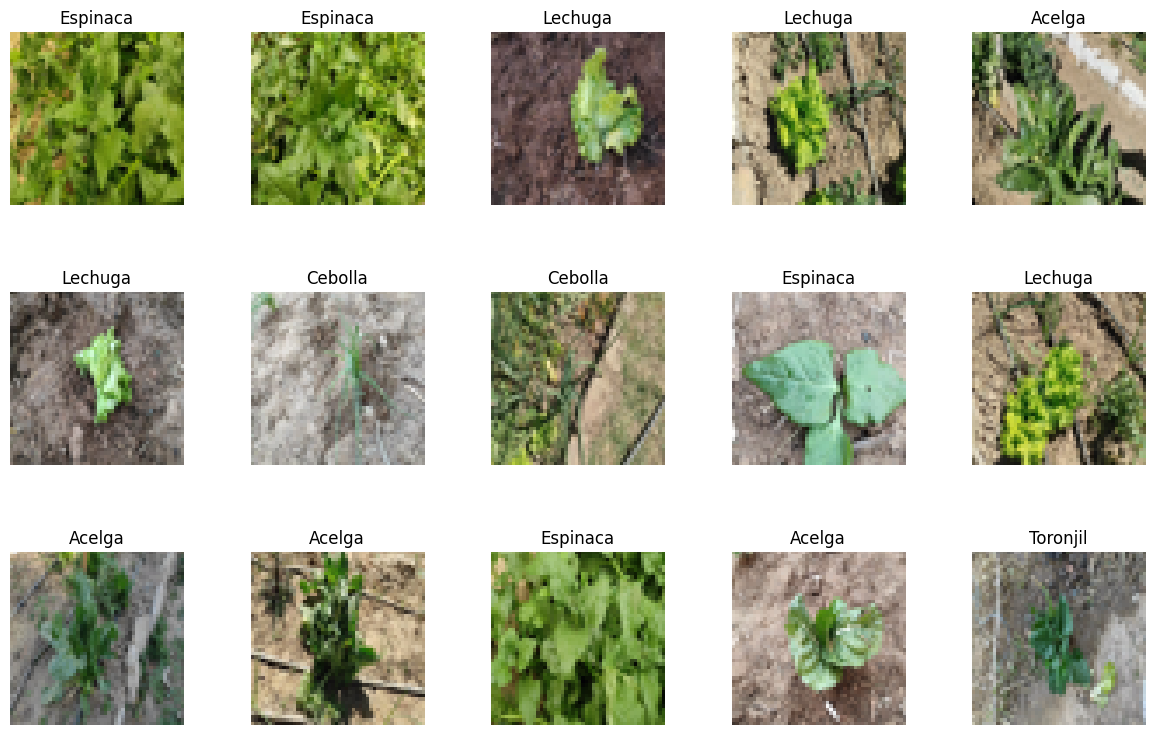

In [ ]:
import random
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        #print(label)A
        #clase_index = classes.index(clase)
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
# convertimos imágenes a arrays de numpy

import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
test_images = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
test_labels = np.array([label for img, label in testset])

In [ ]:
# ver número de imágenes, resolución y número de canales

train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60121, 32, 32, 3), (15000, 32, 32, 3), (60121,), (15000,))

In [ ]:
# tipo de datos

train_images.dtype, train_labels.dtype

(dtype('uint8'), dtype('int64'))

In [ ]:
# estadísiticos

max_value = train_images.max(axis=(0, 1, 2))
min_value = train_images.min(axis=(0, 1, 2))

max_value, min_value

(array([255, 255, 255], dtype=uint8), array([0, 0, 0], dtype=uint8))

In [ ]:
mean = (train_images / 255).mean(axis=(0, 1, 2))
std = (train_images / 255).std(axis=(0, 1, 2))

mean, std

(array([0.52989744, 0.53933566, 0.41685655]),
 array([0.1743679 , 0.15682915, 0.1900853 ]))

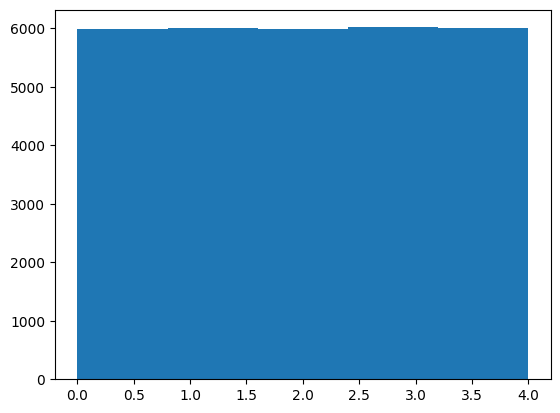

In [ ]:
# distribución de clases

plt.hist(train_labels[:30000], bins=len(classes))
plt.show()

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4]), array([12000, 12009, 12005, 12084, 12023]))

In [ ]:
unique, counts = np.unique(test_labels, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4]), array([3000, 3000, 3000, 3000, 3000]))

##*Validando nuestra red neuronal*

In [ ]:
import torch

# Definimos una función que construye y devuelve un modelo MLP
# D_in: Tamaño de la entrada (32x32x3 representa el tamaño de la imagen aplanada, es decir, imágenes de 32x32 píxeles con 3 canales de color - RGB)
# H: Número de neuronas en las capas ocultas (50 en este caso)
# D_out: Número de neuronas en la capa de salida (en este caso 5 para las plantas)

def build_model(D_in=32*32*3, H=50, D_out=5):
    # Sequential crea una secuencia de capas que se aplicarán una tras otra
    return torch.nn.Sequential(
        # Primera capa densa (capa completamente conectada) que toma una entrada de tamaño D_in (3072)
        # y produce una salida de tamaño H (50 neuronas)
        torch.nn.Linear(D_in, H),  # Capa totalmente conectada
        torch.nn.ReLU(),  # Función de activación ReLU (Rectified Linear Unit)

        # Segunda capa densa, toma la salida de la primera capa (de tamaño H)
        # y produce una salida también de tamaño H
        torch.nn.Linear(H, H),  # Capa totalmente conectada
        torch.nn.ReLU(),  # Otra capa de activación ReLU

        # Capa de salida que toma la salida de la segunda capa oculta (tamaño H) y produce la salida
        # final de tamaño D_out (5 clases en este caso)
        torch.nn.Linear(H, D_out)  # Capa de salida
    )
    # ).cuda()



In [ ]:
# Creamos el modelo llamando a la función previamente definida
model = build_model()
# Creamos una entrada de prueba con un tamaño de batch de 64 y una dimensión de entrada de 32*32*3 (3072)
test_input = torch.randn((64, 32*32*3))  # .cuda()
# Pasamos la entrada de prueba a través del modelo para obtener la salida
test_output = model(test_input)
# Verificamos la forma de la salida
test_output.shape


torch.Size([64, 5])

##Fit de muestra

Una vez nos hemos asegurado que las dimensiones de nuestra red están bien, el siguiente paso es asegurarnos de que es capaz de aprenderse de memoria una sola muestra del dataset. Si este no es el caso podemos estar seguros de que algo no anda bien.

In [ ]:
import numpy as np

# Convertimos las imágenes y etiquetas del conjunto de entrenamiento en arrays de numpy
train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

# Convertimos las etiquetas del conjunto de entrenamiento y prueba en arrays de numpy
train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

# Dividimos el conjunto de entrenamiento en entrenamiento (X_train), validación (X_val) y un subconjunto (X_subset)
X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]

# Hacemos lo mismo para las etiquetas, dividiendo en entrenamiento (y_train), validación (y_val) y un subconjunto (y_subset)
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]

# Imprimimos las formas de los arrays resultantes para verificar las divisiones
X_train.shape, X_val.shape, X_test.shape, X_subset.shape


((40000, 32, 32, 3), (20121, 32, 32, 3), (15000, 32, 32, 3), (5000, 32, 32, 3))

In [ ]:

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        # Convertir X a tensores de PyTorch, normalizar y redimensionar
        self.X = torch.from_numpy(X / 255.).float().view(-1, 32*32*3) # Removed .cuda()
        # Convertir Y a tensores de PyTorch
        self.Y = torch.from_numpy(Y).long() #.cuda()

    def __len__(self):
        # Retornar el tamaño del dataset
        return len(self.X)

    def __getitem__(self, ix):
        # Obtener un elemento del dataset
        return self.X[ix], self.Y[ix]

In [ ]:
# fit de la primera imagen del dataset

dataset = Dataset(X_subset[1:20], y_subset[1:20])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

len(dataset)

19

In [ ]:
epochs = 1000  # Número total de épocas para el entrenamiento
criterion = torch.nn.CrossEntropyLoss()  # Función de pérdida para clasificación
model = build_model()  # Construir el modelo MLP
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Optimizador Adam con tasa de aprendizaje

for e in range(1, epochs+1):  # Iterar sobre cada época
    for x_b, y_b in dataloader:  # Iterar sobre los batches del DataLoader
        y_pred = model(x_b)  # Realizar la predicción
        loss = criterion(y_pred, y_b)  # Calcular la pérdida
        optimizer.zero_grad()  # Limpiar los gradientes anteriores
        loss.backward()  # Retropropagación del error
        optimizer.step()  # Actualizar los pesos del modelo

        # Imprimir el progreso: época actual, pérdida y predicciones
        print(f"Epoch {e}/{epochs} loss {loss.item():.5f} y {y_b.item()} y_pred {torch.argmax(y_pred, axis=1).item()}")


Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 737/1000 loss 1.55939 y 0 y_pred 4
Epoch 737/1000 loss 1.33848 y 3 y_pred 4
Epoch 737/1000 loss 2.25407 y 2 y_pred 4
Epoch 738/1000 loss 1.33959 y 3 y_pred 4
Epoch 738/1000 loss 1.33865 y 3 y_pred 4
Epoch 738/1000 loss 1.33594 y 4 y_pred 4
Epoch 738/1000 loss 1.84585 y 1 y_pred 3
Epoch 738/1000 loss 1.56018 y 0 y_pred 3
Epoch 738/1000 loss 1.33794 y 4 y_pred 3
Epoch 738/1000 loss 1.55973 y 0 y_pred 3
Epoch 738/1000 loss 1.33509 y 3 y_pred 3
Epoch 738/1000 loss 1.33823 y 4 y_pred 3
Epoch 738/1000 loss 1.33446 y 3 y_pred 3
Epoch 738/1000 loss 1.33713 y 4 y_pred 3
Epoch 738/1000 loss 2.25556 y 2 y_pred 3
Epoch 738/1000 loss 1.84995 y 1 y_pred 3
Epoch 738/1000 loss 1.55981 y 0 y_pred 3
Epoch 738/1000 loss 1.33374 y 4 y_pred 3
Epoch 738/1000 loss 1.84930 y 1 y_pred 4
Epoch 738/1000 loss 1.55939 y 0 y_pred 4
Epoch 738/1000 loss 1.33848 y 3 y_pred 4
Epoch 738/1000 loss 2.25407 y 2 y_pred 4
Epoch 739/1000 loss 1.33959 y 3 y_pre

Mientras probamos con mas de 1000 epochs podemos ver que solo reconocerá los 19 batches prediciendo las etiquetas en los 1000 epochs.

Podemos hacer el fit de una imagen sin problema. Errores como una función de pérdida incorrecta o diferentes dimensiones entre las predicciones y las etiquetas podrían ser detectados en este paso.

###FIT de un Batch

Siguiendo la misma lógica, nuestro modelo debería ser capaz de aprenderse de memoria un solo batch de imágenes.

In [ ]:
# fit de un batch

dataset = Dataset(X_subset[:64], y_subset[:64])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

len(dataset)

64

In [ ]:
epochs = 500
criterion = torch.nn.CrossEntropyLoss()
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for e in range(1, epochs+1):
    for x_b, y_b in dataloader:
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (y_b == torch.argmax(y_pred, axis=1)).sum().item()
        if not e % 10:
            print(f"Epoch {e}/{epochs} loss {loss.item():.5f} acc {acc}/{y_b.shape[0]}")

Epoch 10/500 loss 1.54143 acc 21/64
Epoch 20/500 loss 1.43043 acc 36/64
Epoch 30/500 loss 1.09610 acc 36/64
Epoch 40/500 loss 0.68831 acc 47/64
Epoch 50/500 loss 0.46427 acc 50/64
Epoch 60/500 loss 0.32098 acc 55/64
Epoch 70/500 loss 0.24060 acc 57/64
Epoch 80/500 loss 0.18662 acc 61/64
Epoch 90/500 loss 0.12861 acc 61/64
Epoch 100/500 loss 0.07914 acc 63/64
Epoch 110/500 loss 0.04427 acc 64/64
Epoch 120/500 loss 0.02471 acc 64/64
Epoch 130/500 loss 0.01588 acc 64/64
Epoch 140/500 loss 0.01139 acc 64/64
Epoch 150/500 loss 0.00868 acc 64/64
Epoch 160/500 loss 0.00695 acc 64/64
Epoch 170/500 loss 0.00576 acc 64/64
Epoch 180/500 loss 0.00488 acc 64/64
Epoch 190/500 loss 0.00421 acc 64/64
Epoch 200/500 loss 0.00369 acc 64/64
Epoch 210/500 loss 0.00326 acc 64/64
Epoch 220/500 loss 0.00291 acc 64/64
Epoch 230/500 loss 0.00262 acc 64/64
Epoch 240/500 loss 0.00237 acc 64/64
Epoch 250/500 loss 0.00216 acc 64/64
Epoch 260/500 loss 0.00198 acc 64/64
Epoch 270/500 loss 0.00182 acc 64/64
Epoch 280/

En este punto ya podemos estar bastante seguros de que nuestro modelo está bien definido, estamos usando la función de pérdida y optimizador adecuados, nuestro bucle de entrenamiento funciona bien, etc.

## Entrenando con un sub-conjunto de datos

In [ ]:

# Definimos el dataset con un subconjunto de datos para entrenamiento y validación
dataset = {
    'train': Dataset(X_subset, y_subset),  # Dataset para entrenamiento usando el subconjunto de datos
    'val': Dataset(X_val, y_val),          # Dataset para validación usando el conjunto de validación
}

# Creamos los DataLoaders para manejar el entrenamiento y la validación
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),  # DataLoader para entrenamiento
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)   # DataLoader para validación
}

# Mostramos el tamaño del dataset de entrenamiento y validación
len(dataset['train']), len(dataset['val'])


(5000, 20121)

In [ ]:
from sklearn.metrics import accuracy_score

def softmax(x):
    """
    Calcula la función softmax para la entrada x.

    """
    return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)

def fit(model, dataloader, optimizer, scheduler=None, epochs=1000, log_each=1, weight_decay=0, early_stopping=0, verbose=1):
    """
    Entrena el modelo con el DataLoader proporcionado.
    Args:
        model (torch.nn.Module): El modelo a entrenar.
        dataloader (dict): Diccionario con DataLoaders para entrenamiento y validación.
        optimizer (torch.optim.Optimizer): Optimizador para actualizar los parámetros del modelo.
        scheduler (torch.optim.lr_scheduler, optional): Scheduler para ajustar la tasa de aprendizaje.
        epochs (int): Número de épocas para entrenar.
        log_each (int): Frecuencia para registrar el progreso del entrenamiento.
        weight_decay (float, optional): Decaimiento del peso para el optimizador.
        early_stopping (int, optional): Número de épocas sin mejora antes de detener el entrenamiento.
        verbose (int): Nivel de verbosidad (0 = nada, 1 = básico, 2 = detallado).
    Returns:
        dict: Resultados del entrenamiento (épocas, pérdida, precisión, etc.).
    """
    criterion = torch.nn.CrossEntropyLoss()  # Función de pérdida para clasificación
    l, acc, lr = [], [], []  # Listas para guardar pérdidas, precisión y tasa de aprendizaje
    val_l, val_acc = [], []  # Listas para pérdidas y precisión de validación
    best_acc, step = 0, 0  # Mejor precisión y contador de pasos para early stopping

    for e in range(1, epochs + 1):
        _l, _acc = [], []  # Listas para pérdidas y precisión en cada época
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])  # Guardar tasa de aprendizaje actual

        model.train()  # Configura el modelo en modo entrenamiento

        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)  # Realizar predicciones
            loss = criterion(y_pred, y_b)  # Calcular pérdida
            _l.append(loss.item())  # Guardar pérdida
            optimizer.zero_grad()  # Limpiar gradientes
            loss.backward()  # Calcular gradientes
            optimizer.step()  # Actualizar parámetros

            y_probas = torch.argmax(softmax(y_pred), axis=1)  # Obtener predicciones de clase
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))  # Calcular precisión

        l.append(np.mean(_l))  # Promediar pérdida de entrenamiento
        acc.append(np.mean(_acc))  # Promediar precisión de entrenamiento

        model.eval()  # Configura el modelo en modo evaluación
        _l, _acc = [], []  # Listas para pérdidas y precisión en validación

        with torch.no_grad():  # Desactiva el cálculo de gradientes
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)  # Realizar predicciones
                loss = criterion(y_pred, y_b)  # Calcular pérdida
                _l.append(loss.item())  # Guardar pérdida
                y_probas = torch.argmax(softmax(y_pred), axis=1)  # Obtener predicciones de clase
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))  # Calcular precisión

        val_l.append(np.mean(_l))  # Promediar pérdida de validación
        val_acc.append(np.mean(_acc))  # Promediar precisión de validación

        # Guardar el mejor modelo basado en precisión de validación
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')  # Guardar el estado del modelo
            step = 0
            if verbose == 2:
                print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")

        step += 1  # Incrementar contador de pasos
        if scheduler:
            scheduler.step()  # Actualizar tasa de aprendizaje si se usa un scheduler

        # Early stopping si no hay mejora en el número de épocas especificado
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break

        # Registrar el progreso del entrenamiento
        if not e % log_each and verbose:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")

    # Cargar el mejor modelo guardado
    model.load_state_dict(torch.load('ckpt.pt'))

    return {'epoch': list(range(1, len(l) + 1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}


Por ejemplo, de la siguiente manera podríamos elegir un learning rate adecuado.

In [ ]:
lrs = [0.003, 0.0002, 0.0001]
hists = []
for lr in lrs:
    print(f"Probando lr {lr}")
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = fit(model, dataloader, optimizer, epochs=100, verbose=0)
    hists.append(hist)

# tarda 5 minutos

Probando lr 0.0005
Probando lr 0.0002
Probando lr 0.0001


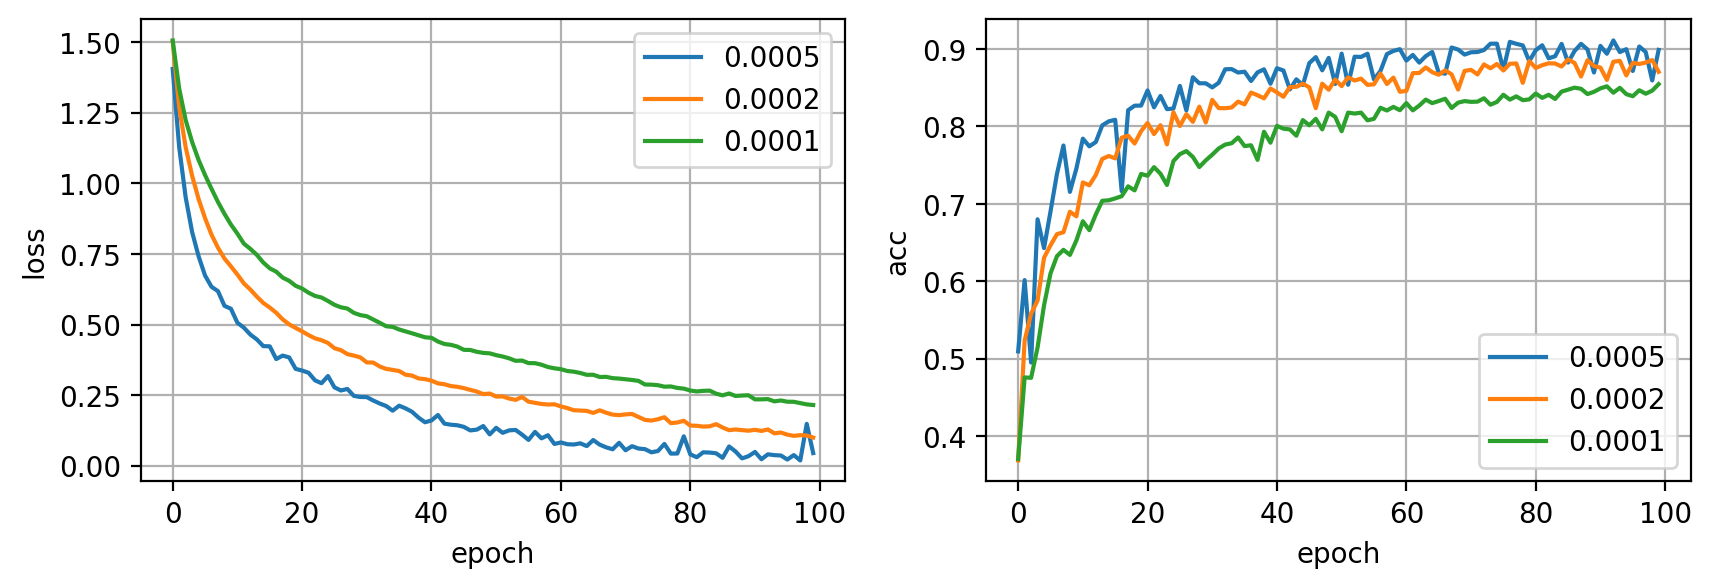

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(lrs)):
    ax.plot(hists[i]['loss'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(lrs)):
    ax.plot(hists[i]['val_acc'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Parece que el valor intermedio de 0.001 nos da los mejores resultados en este caso. Ahora repetimos el experimento con todos los datos.

In [ ]:
dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val[:20000], y_val[:20000]),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 20000)

In [ ]:
hists = []
for lr in lrs:
    print(f"Probando lr {lr}")
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = fit(model, dataloader, optimizer, epochs=100, verbose=0)
    hists.append(hist)

# tarda 1 minuto y 17 segundos

Probando lr 0.0005
Probando lr 0.0002
Probando lr 0.0001


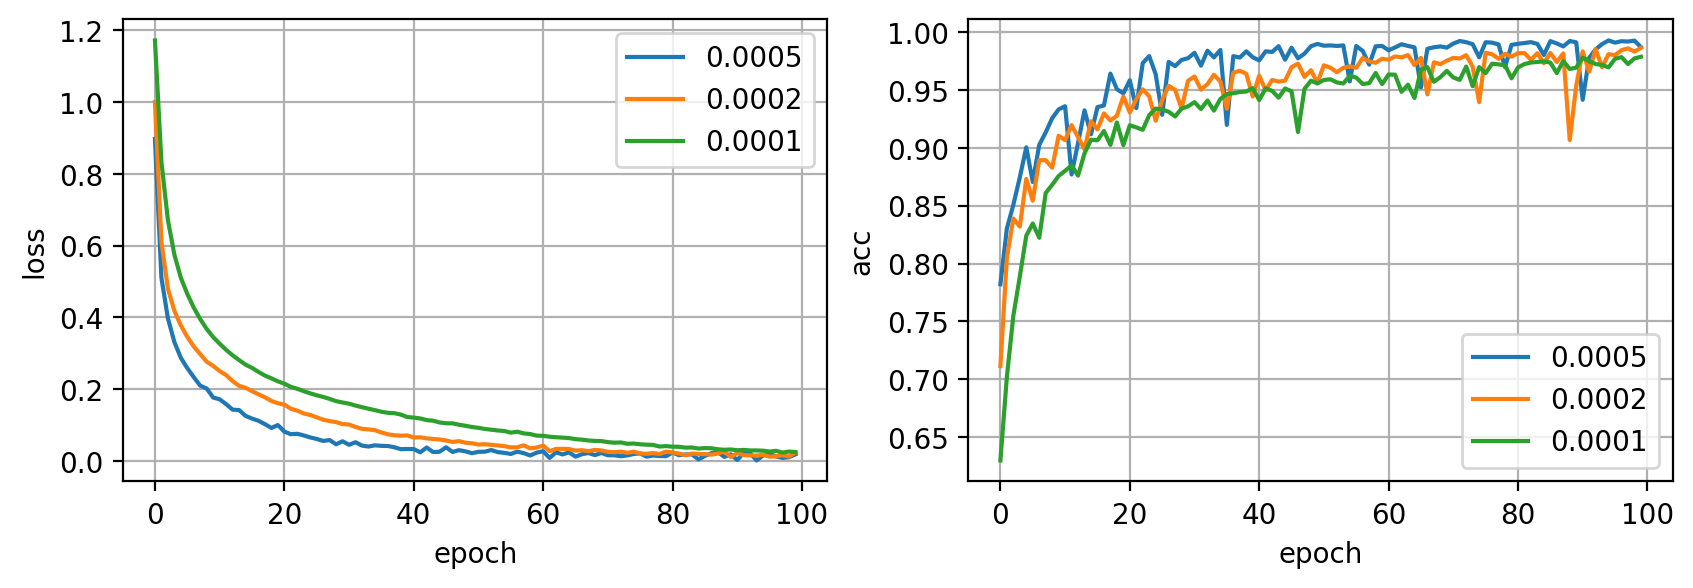

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(lrs)):
    ax.plot(hists[i]['loss'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(lrs)):
    ax.plot(hists[i]['val_acc'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Obtenemos el mismo resultado, pero necesitando mucho más tiempo y cálculo. Así pues, experimentar rápidamente en un subconjunto representativo nos puede dar una gran ventaja.

##Configuraciones recomendadas

Es fácil verse sobrepasado por el gran número de opciones que tenemos disponibles a la hora de entrenar nuestras redes, y obviamente no podemos probar todas las posibles combinaciones. Lo que podemos hacer es basarnos en el trabajo llevado a cabo por otros y utilizar sus resultados para empezar a trabajar. Estos son algunos buenos valores iniciales que puedes usar.

## Batch Size

Valores recomendados son: 16, 32, 64. Puedes empezar por estos valores y luego experimentar con otros. Aún así, la tendencia es intentar utilizar el batch size más grande posible que quepa en la memoria de la GPU (o GPUs) y adaptar el learning rate para obtener un buen entrenamiento.

In [ ]:
bss = [16, 32, 64]
hists = []
for bs in bss:
    print(f"Probando bs {bs}")
    dataloader = {
        'train': torch.utils.data.DataLoader(dataset['train'], batch_size=bs, shuffle=True),
        'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
    }

    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    hist = fit(model, dataloader, optimizer, epochs=10, verbose=0)
    hists.append(hist)

Probando bs 16
Probando bs 32
Probando bs 64


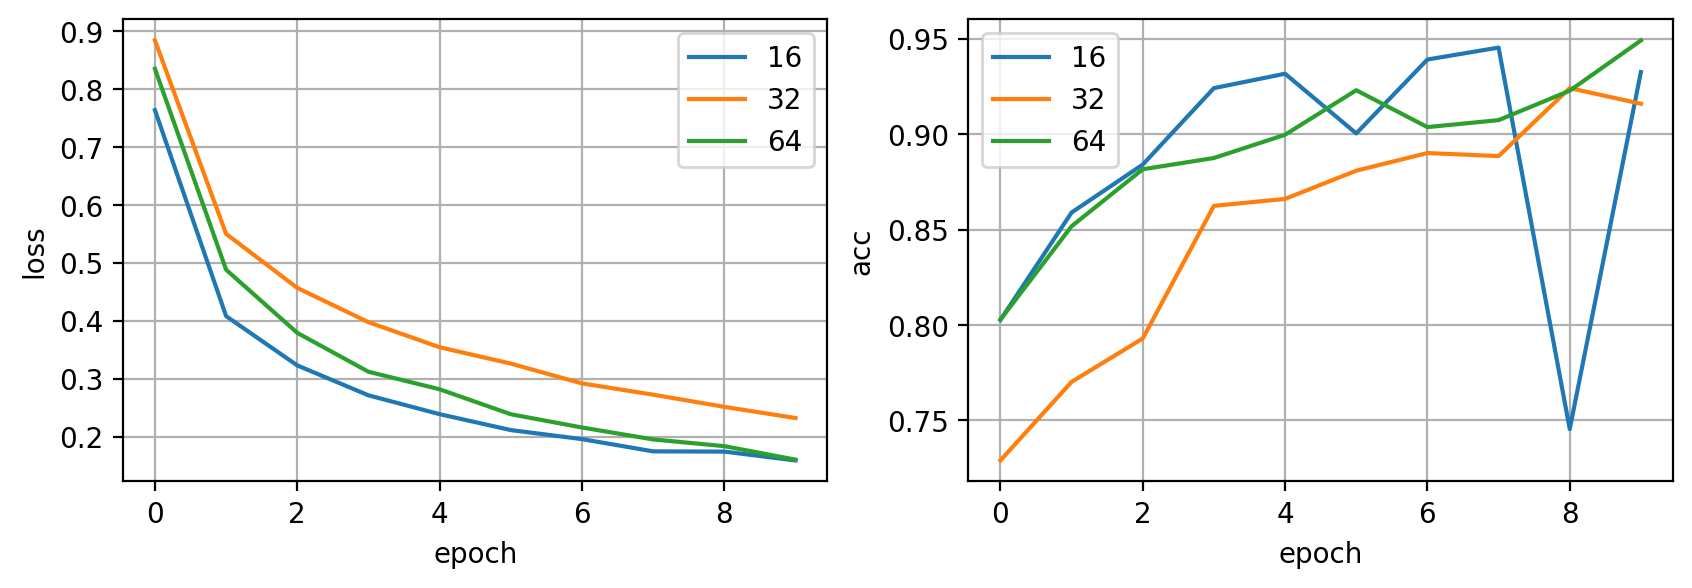

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(bss)):
    ax.plot(hists[i]['loss'], label=bss[i])
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(bss)):
    ax.plot(hists[i]['val_acc'], label=bss[i])
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

## Optimizador y learning rate

Un buena combinación inicial es el optimizador Adam con un learning rate de  0.001 . A partir de aquí puede experimentar con otros valores para sacar un extra de performance, pero estos valores suelen ser buenos para empezar.

## REGULARIZACIÓN

Cuando trabajamos con imágenes, utilizar data augmentation y batch norm es muy aconsejable para obtener buenos resultados. Combinándolo con early stopping seremos capaces de maneter el overfitting a raya. Puedes usar Weight decay si utilizas el optimizador SGD para regularizar mnás tu modelo, e incluso probar Dropout

In [ ]:
import torch

def build_model(D_in=32*32*3, H=50, D_out=5):
    return torch.nn.Sequential(
        # Capa totalmente conectada con tamaño de entrada D_in y salida H
        torch.nn.Linear(D_in, H),
        # Normalización por lotes en la primera capa oculta
        torch.nn.BatchNorm1d(H),
        # Función de activación ReLU
        torch.nn.ReLU(),
        # Segunda capa totalmente conectada con tamaño de entrada H y salida H
        torch.nn.Linear(H, H),
        # Normalización por lotes en la segunda capa oculta
        torch.nn.BatchNorm1d(H),
        # Función de activación ReLU
        torch.nn.ReLU(),
        # Capa de salida con tamaño de entrada H y salida D_out (número de clases)
        torch.nn.Linear(H, D_out)
    )  #.cuda()


In [ ]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

# Definimos un conjunto de transformaciones que se aplicarán a las imágenes
trans = Compose([
    RandomCrop(24,24),
    Resize(32, 32),
    HorizontalFlip(),
    OneOf([
        ToGray(p=0.2),
        RGBShift(p=0.3)
    ])
])
# Clase Dataset personalizada para manejar los datos de entrenamiento y validación
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        img = self.X[ix]      # Obtiene la imagen en la posición i
        if self.trans:
            img = trans(image=img)["image"]  # Aplica las transformaciones a la imagen
        img = torch.from_numpy(img / 255.).float().view(-1) #.cuda() # Normaliza y convierte la imagen a tensor
        label = torch.tensor(self.Y[ix]).long() #.cuda()  # Convierte la etiqueta a tensor
        return img, label

# Se crean los datasets de entrenamiento y validación
dataset = {
    'train': Dataset(X_subset, y_subset, trans=trans),  # Dataset de entrenamiento con transformaciones
    'val': Dataset(X_val[:20000], y_val[:20000]),       # Dataset de validación sin transformaciones
}

# Se crean los dataloaders para cargar los datos en lotes
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),  # Entrenamiento en lotes de 64
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)    # Validación en lotes de 1000
}

# Imprime la longitud de los datasets de entrenamiento y validación
len(dataset['train']), len(dataset['val'])


(5000, 20000)

In [ ]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist = fit(model, dataloader, optimizer, epochs=100, early_stopping=20, verbose=2)

Mejor modelo guardado con acc 0.43605 en epoch 1
Epoch 1/100 loss 1.20092 acc 0.52591 val_loss 1.51944 val_acc 0.43605 lr 0.00100
Epoch 2/100 loss 1.00628 acc 0.61116 val_loss 1.51310 val_acc 0.39985 lr 0.00100
Mejor modelo guardado con acc 0.64740 en epoch 3
Epoch 3/100 loss 0.91925 acc 0.65249 val_loss 0.89673 val_acc 0.64740 lr 0.00100
Epoch 4/100 loss 0.87450 acc 0.66475 val_loss 0.84989 val_acc 0.62695 lr 0.00100
Mejor modelo guardado con acc 0.65150 en epoch 5
Epoch 5/100 loss 0.83655 acc 0.68176 val_loss 0.82600 val_acc 0.65150 lr 0.00100
Mejor modelo guardado con acc 0.75050 en epoch 6
Epoch 6/100 loss 0.80865 acc 0.69403 val_loss 0.66696 val_acc 0.75050 lr 0.00100
Epoch 7/100 loss 0.78675 acc 0.70016 val_loss 1.11856 val_acc 0.57955 lr 0.00100
Epoch 8/100 loss 0.73183 acc 0.72290 val_loss 0.84493 val_acc 0.67650 lr 0.00100
Epoch 9/100 loss 0.74445 acc 0.71381 val_loss 0.70814 val_acc 0.73635 lr 0.00100
Epoch 10/100 loss 0.75324 acc 0.70411 val_loss 0.68004 val_acc 0.74525 lr 0

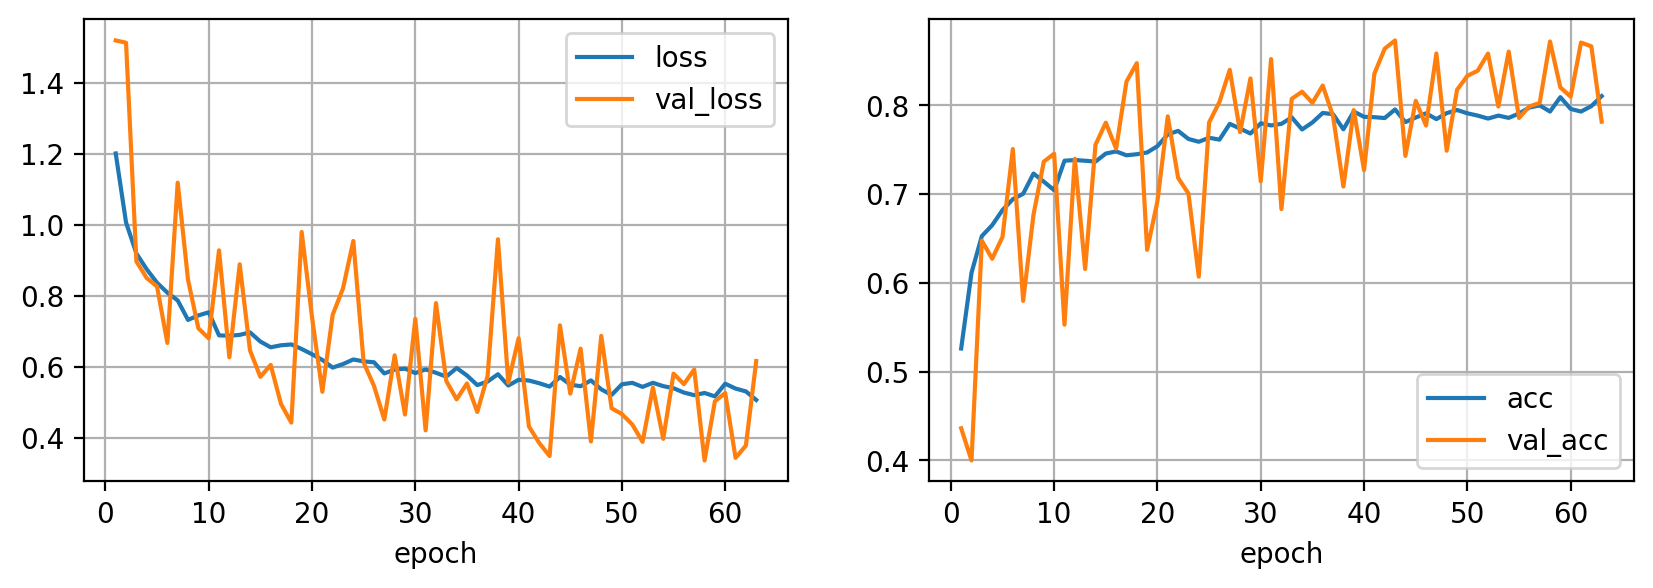

In [ ]:
import pandas as pd

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

##**Tuneado de Hyperparámetros**

In [ ]:
# Definimos los posibles valores de los hiperparámetros: batch size (bss) y learning rate (lrs)
bss = [16, 32, 64, 128, 256]  # Diferentes tamaños de batch que queremos probar
lrs = [0.01, 0.005, 0.001, 0.0003, 0.0001]  # Diferentes valores de learning rate a probar

n = 5  # Número de experimentos a realizar
hists = []  # Lista para almacenar los resultados (historial de entrenamiento) de cada prueba

# Iteramos n veces para realizar una búsqueda aleatoria de hiperparámetros
for i in range(n):
    # Seleccionamos aleatoriamente un learning rate y un batch size de las listas
    lr = random.choice(lrs)
    bs = random.choice(bss)

    # Mostramos los valores de lr y bs seleccionados para esta prueba
    print(f"Test {i+1} lr {lr} bs {bs}")

    # Creamos el dataloader para entrenamiento y validación usando el batch size seleccionado
    dataloader = {
        'train': torch.utils.data.DataLoader(dataset['train'], batch_size=bs, shuffle=True),
        'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
    }

    # Construimos un nuevo modelo para cada prueba
    model = build_model()

    # Creamos el optimizador Adam con el learning rate seleccionado
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Entrenamos el modelo con los datos y guardamos el historial del entrenamiento
    hist = fit(model, dataloader, optimizer, epochs=20, verbose=0)

    # Guardamos el historial y los hiperparámetros utilizados para esta prueba
    hists.append({'hist': hist, 'lr': lr, 'bs': bs})


Test 1 lr 0.001 bs 128
Test 2 lr 0.0001 bs 16
Test 3 lr 0.0001 bs 64
Test 4 lr 0.0001 bs 16
Test 5 lr 0.005 bs 128


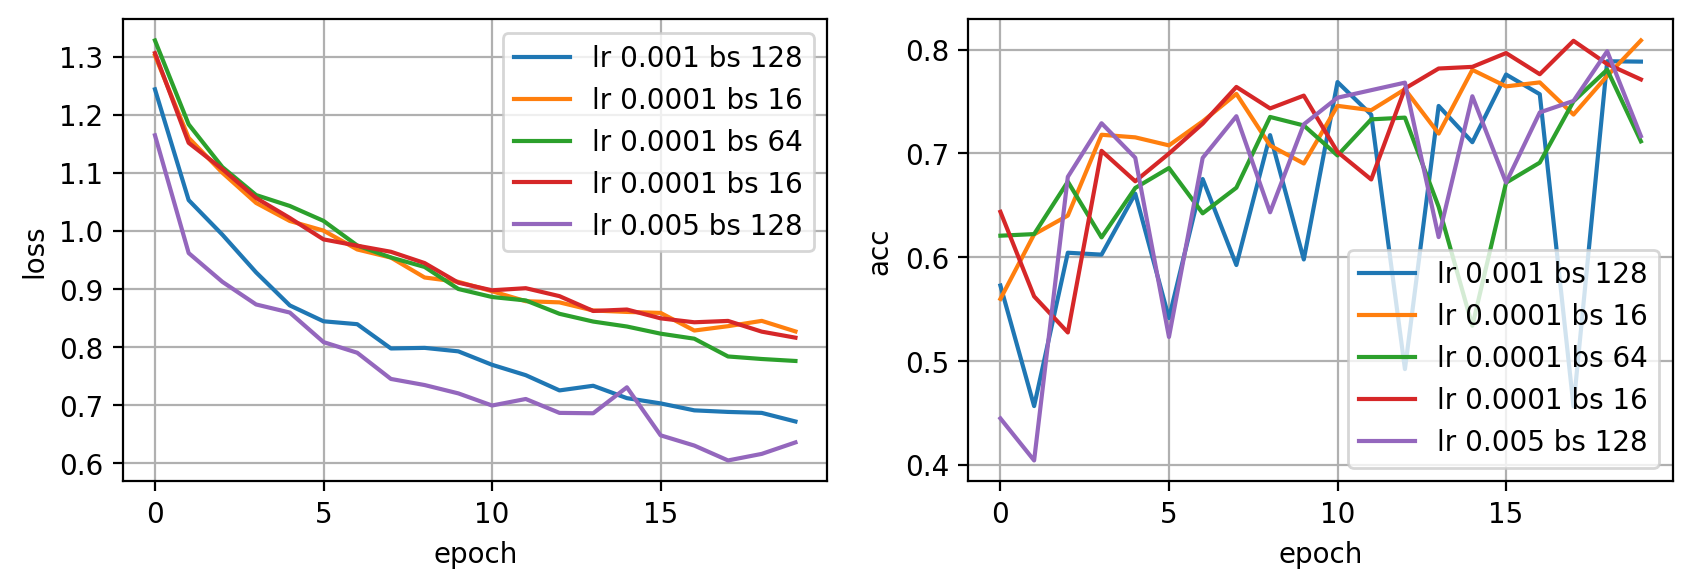

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(hists)):
    ax.plot(hists[i]['hist']['loss'], label=f'lr {hists[i]["lr"]} bs {hists[i]["bs"]}')
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(hists)):
    ax.plot(hists[i]['hist']['val_acc'], label=f'lr {hists[i]["lr"]} bs {hists[i]["bs"]}')
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

##Últimos toques

Y ya para terminar, puedemos experimentar con varios schedulers que vayan modificando el learning rate durante el entrenamiento. Esta técnica es especialmente interesante en combinación con transfer learning, algo de lo que hablaremos en detalle más adelante.

In [ ]:
# Crear el modelo
model = build_model()

# Inicializar el optimizador Adam con learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Crear un scheduler para reducir el learning rate cada 20 epochs multiplicando por 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Entrenar el modelo con 100 epochs, usando el scheduler y early stopping si no mejora en 10 epochs
hist = fit(model, dataloader, optimizer, scheduler=scheduler, epochs=100, early_stopping=10, verbose=2)


Mejor modelo guardado con acc 0.57870 en epoch 1
Epoch 1/100 loss 1.23489 acc 0.51152 val_loss 1.05978 val_acc 0.57870 lr 0.00100
Epoch 2/100 loss 1.04854 acc 0.58926 val_loss 1.23067 val_acc 0.44760 lr 0.00100
Epoch 3/100 loss 0.97974 acc 0.62090 val_loss 1.10573 val_acc 0.53965 lr 0.00100
Mejor modelo guardado con acc 0.62315 en epoch 4
Epoch 4/100 loss 0.93932 acc 0.63359 val_loss 0.98977 val_acc 0.62315 lr 0.00100
Epoch 5/100 loss 0.89141 acc 0.66855 val_loss 1.31653 val_acc 0.56340 lr 0.00100
Epoch 6/100 loss 0.84213 acc 0.67676 val_loss 1.89036 val_acc 0.39365 lr 0.00100
Epoch 7/100 loss 0.83851 acc 0.67949 val_loss 1.28274 val_acc 0.49795 lr 0.00100
Mejor modelo guardado con acc 0.68015 en epoch 8
Epoch 8/100 loss 0.82354 acc 0.68887 val_loss 0.82065 val_acc 0.68015 lr 0.00100
Epoch 9/100 loss 0.78864 acc 0.70547 val_loss 0.98415 val_acc 0.56570 lr 0.00100
Epoch 10/100 loss 0.78528 acc 0.70137 val_loss 0.76395 val_acc 0.67780 lr 0.00100
Mejor modelo guardado con acc 0.72310 en e

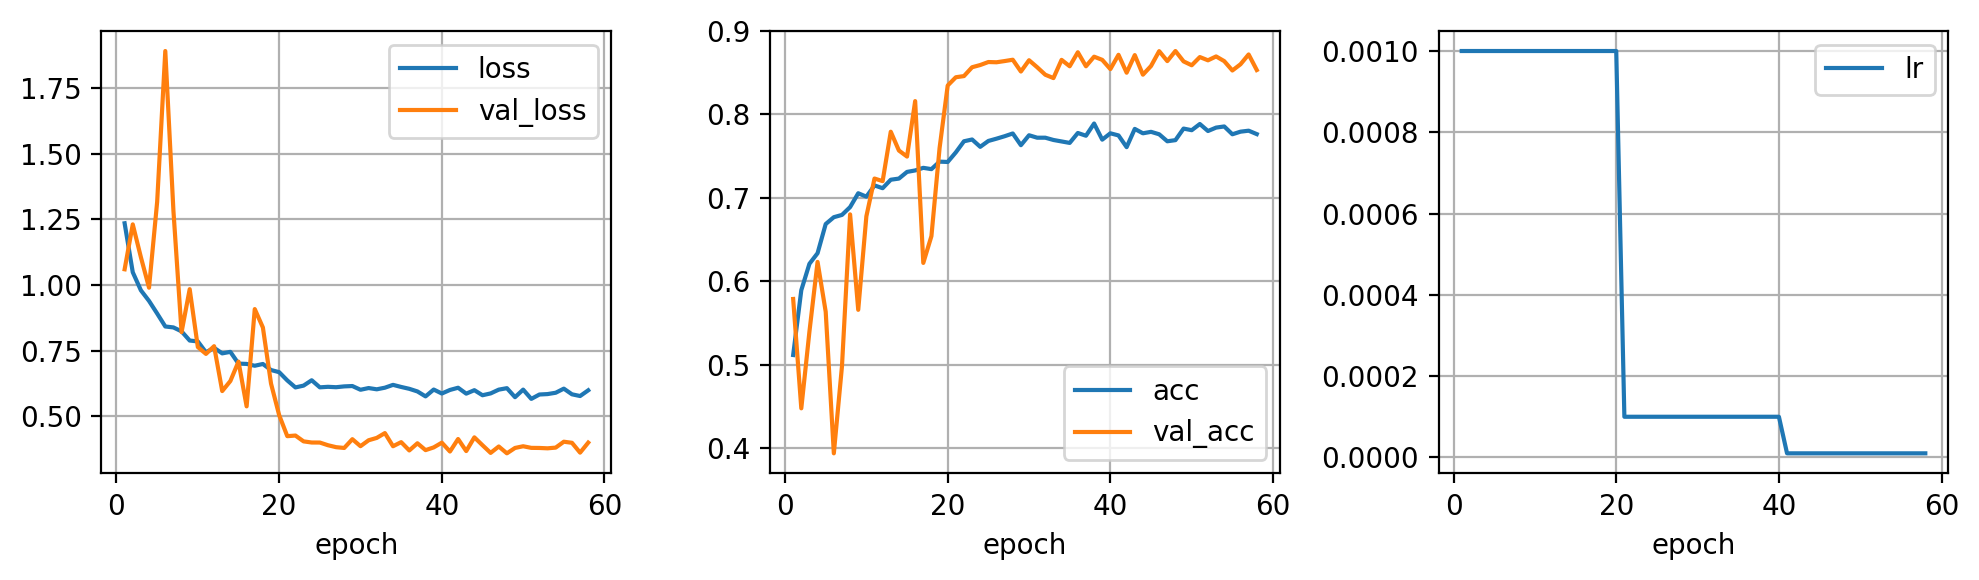

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(131)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(132)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
ax = plt.subplot(133)
pd.DataFrame(hist).plot(x='epoch', y=['lr'], grid=True, ax=ax)
plt.tight_layout()
plt.show()

Utilizamos todos los datos una vez hayamos encontrado una buena combinación de hyperparámetros en nuestro subset.

In [ ]:
dataset = {
    'train': Dataset(X_train, y_train, trans=trans),
    'val': Dataset(X_val[:20000], y_val[:20000]),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 20000)

In [ ]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.1)
hist = fit(model, dataloader, optimizer, scheduler, epochs=100, early_stopping=10, verbose=2)

Mejor modelo guardado con acc 0.66640 en epoch 1
Epoch 1/100 loss 0.88418 acc 0.65785 val_loss 0.81270 val_acc 0.66640 lr 0.00100
Mejor modelo guardado con acc 0.77770 en epoch 2
Epoch 2/100 loss 0.68624 acc 0.73462 val_loss 0.62010 val_acc 0.77770 lr 0.00100
Mejor modelo guardado con acc 0.82430 en epoch 3
Epoch 3/100 loss 0.61038 acc 0.76582 val_loss 0.47599 val_acc 0.82430 lr 0.00100
Epoch 4/100 loss 0.57758 acc 0.77905 val_loss 0.73150 val_acc 0.72555 lr 0.00100
Epoch 5/100 loss 0.54923 acc 0.78753 val_loss 0.52828 val_acc 0.81190 lr 0.00100
Epoch 6/100 loss 0.53318 acc 0.79668 val_loss 1.24765 val_acc 0.64280 lr 0.00100
Epoch 7/100 loss 0.51403 acc 0.80135 val_loss 0.67128 val_acc 0.76065 lr 0.00100
Mejor modelo guardado con acc 0.85705 en epoch 8
Epoch 8/100 loss 0.50364 acc 0.80507 val_loss 0.39853 val_acc 0.85705 lr 0.00100
Epoch 9/100 loss 0.48759 acc 0.81115 val_loss 0.53251 val_acc 0.81365 lr 0.00100
Mejor modelo guardado con acc 0.86345 en epoch 10
Epoch 10/100 loss 0.48521

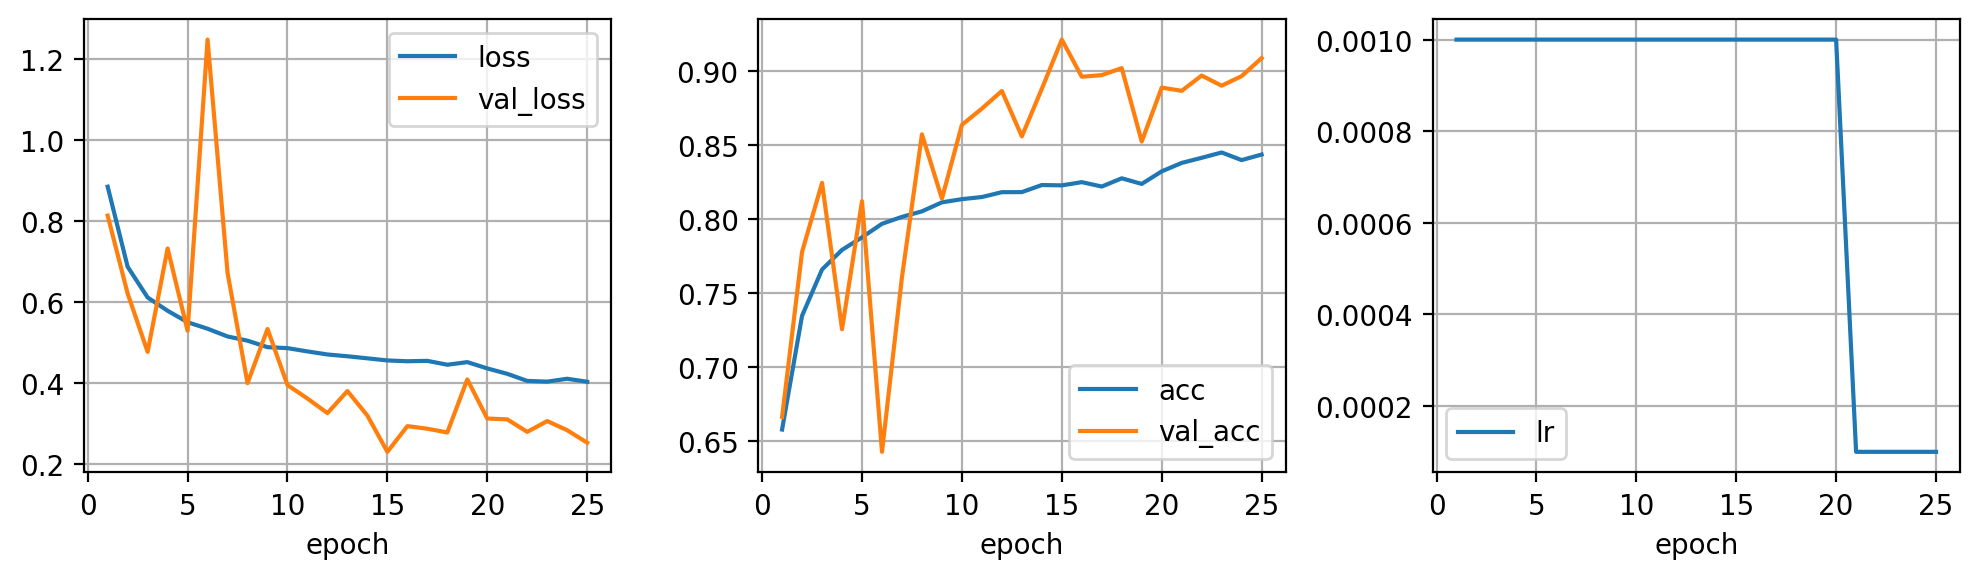

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(131)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(132)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
ax = plt.subplot(133)
pd.DataFrame(hist).plot(x='epoch', y=['lr'], grid=True, ax=ax)
plt.tight_layout()
plt.show()

##**CONCLUSIÓN SOBRE LAS BUENAS RECETAS**

Aplicando este post sobre las buenas recetas pudimos obtener buenos resultados pobrando con muchos valores de batch y epochs.

Ademas para mejorar el modelo que vayamos guardando tendriamos que buscar las mejores valores iniciales para una buena práctica.

##========================================================================================================

# **2. APLICANDO LOS CONCEPTOS DE REGULARIZACIÓN**


La regularización es una implementación muy importe ya que nos permite evitar el Overfiting que el modelo trata de memorizar los datos.

Este dataset que este caso de las plantas medicinales está formado por imágenes en color de baja resolución, tenemos 60000 imágenes de entrenamiento y 15000 de test y el objetivo es el clasificar en 5 clases diferentes de plantas. Veamos algunos ejemplos.

#Importación del Dataset

In [ ]:
# Funcion para cargar nuestro dataset de entrenamiento TRAIN

def cargar_dataset_train_(ruta_dataset, tamaño_imagen=(50, 50)):
    # Reiniciar variables
    dataset = []
    etiquetas_mapping = {}

    # Obtener clases del nuevo dataset y ordenarlas
    clases = sorted(os.listdir(ruta_dataset))

    # Mapeo de etiquetas a valores numéricos
    etiquetas_mapping = {clase: idx for idx, clase in enumerate(clases)}

    for clase in clases:
        #print(f"Procesando clase testing: {clase} ({etiquetas_mapping[clase]})")
        ruta_clase = os.path.join(ruta_dataset, clase)
        etiqueta_num = etiquetas_mapping[clase]  # Obtener el valor numérico de la etiqueta directamente
        with os.scandir(ruta_clase) as entries:
            for idx, entry in enumerate(entries, start=1):
                if entry.is_file():
                    imagen_ruta = os.path.join(ruta_clase, entry.name)
                    # Abrir imagen como objeto PIL
                    imagen = Image.open(imagen_ruta).convert('RGB')

                    # Normalizar la imagen
                    imagen = np.array(imagen) / 255.0

                    # Convertir la imagen normalizada a objeto PIL
                    imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))

                    # Redimensionar imagen
                    imagen_resized = imagen_pil.resize(tamaño_imagen)
                    dataset.append((imagen_resized, etiqueta_num))  # Tupla con imagen y etiqueta numérica

    random.shuffle(dataset)
    return dataset



In [ ]:
# Funcion para cargar nuestro dataset de prueb TEST

def cargar_dataset_test_(ruta_dataset, tamaño_imagen=(50, 50)):
    # Reiniciar variables
    dataset = []
    etiquetas_mapping = {}

    # Obtener clases del nuevo dataset y ordenarlas
    clases = sorted(os.listdir(ruta_dataset))

    # Mapeo de etiquetas a valores numéricos
    etiquetas_mapping = {clase: idx for idx, clase in enumerate(clases)}

    for clase in clases:
        #print(f"Procesando clase testing: {clase} ({etiquetas_mapping[clase]})")
        ruta_clase = os.path.join(ruta_dataset, clase)
        etiqueta_num = etiquetas_mapping[clase]  # Obtener el valor numérico de la etiqueta directamente
        with os.scandir(ruta_clase) as entries:
            for idx, entry in enumerate(entries, start=1):
                if entry.is_file():
                    imagen_ruta = os.path.join(ruta_clase, entry.name)

                    # Abrir imagen como objeto PIL
                    imagen = Image.open(imagen_ruta).convert('RGB')

                    # Normalizar la imagen
                    imagen = np.array(imagen) / 255.0

                    # Convertir la imagen normalizada a objeto PIL
                    imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))

                    # Redimensionar imagen
                    imagen_resized = imagen_pil.resize(tamaño_imagen)
                    dataset.append((imagen_resized, etiqueta_num))  # Tupla con imagen y etiqueta numérica

    random.shuffle(dataset)
    return dataset



In [ ]:
# Cargamos nuestro dataset de la imagenes

trainset_ = cargar_dataset_train_('/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_train')
testset_ = cargar_dataset_test_('/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_test')

print("Número de ejemplos en el conjunto de entrenamiento:", len(trainset_))
print("Número de ejemplos en el conjunto de prueba:", len(testset_))

Este dataset está formado por imágenes en color de baja resolución, tenemos 60000 imágenes de entrenamiento y 15000 de test y el objetivo es el clasificar en 5 clases diferentes. Veamos algunos ejemplos.

In [ ]:
# GUARDAMOS EL DATASET EN UN ARCHIVO .NPZ
import numpy as np

# Convertir dataset a arrays NumPy
def convertir_a_numpy(dataset):
    imagenes = np.array([np.array(imagen) for imagen, etiqueta in dataset])
    etiquetas = np.array([etiqueta for imagen, etiqueta in dataset])
    return imagenes, etiquetas

# Convertir datasets de entrenamiento y prueba a NumPy
train_images, train_labels = convertir_a_numpy(trainset_)
test_images, test_labels = convertir_a_numpy(testset_)

# Guardar datasets en archivos .npz
np.savez('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_train.npz', images=train_images, labels=train_labels)
np.savez('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_test.npz', images=test_images, labels=test_labels)

print("Datasets guardados exitosamente en archivos .npz")


Datasets guardados exitosamente en archivos .npz


In [ ]:
# CARGAMOS LOS DATASET DE ENTRENAMIENTO Y PRUEBA

# Cargar dataset de entrenamiento
train_data = np.load('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_train.npz')
train_images, train_labels = train_data['images'], train_data['labels']

# Cargar dataset de prueba
test_data = np.load('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_test.npz')
test_images, test_labels = test_data['images'], test_data['labels']

print("Datasets cargados exitosamente desde los archivos .npz")
print("Número de ejemplos en el conjunto de entrenamiento:", len(train_images))
print("Número de ejemplos en el conjunto de prueba:", len(test_images))


Datasets cargados exitosamente desde los archivos .npz
Número de ejemplos en el conjunto de entrenamiento: 60000
Número de ejemplos en el conjunto de prueba: 15000


In [ ]:
# Nombramos los nombres de las clases que tendran nuestro dataset
classes = ('Acelga', 'Cebolla', 'Espinaca', 'Lechuga', 'Toronjil')

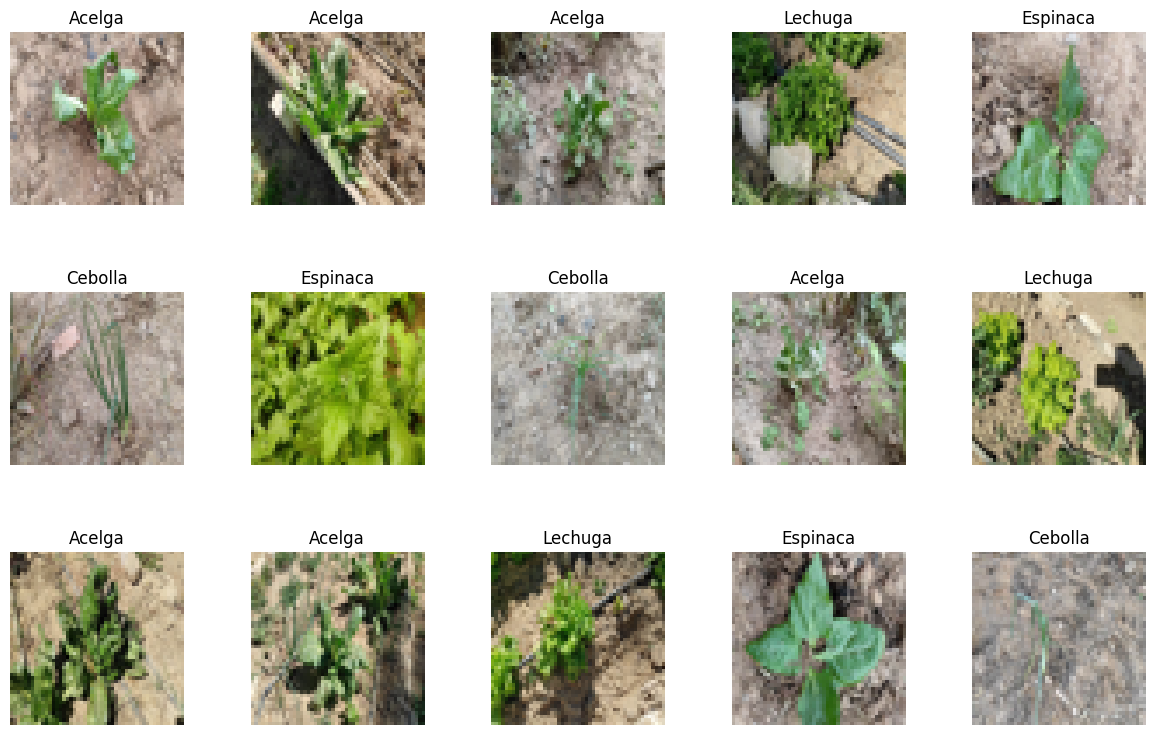

In [ ]:
import random
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset_)-1)
        img, label = trainset_[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Vamos a transformar las imágenes en arrays de NumPy para poder manejarlas de la misma manera que hemos hecho hasta ahora en los posts anteriores. También separaremos un conjunto de imágenes para validación así como un subset de imágenes para entrenar más rápido.

In [ ]:
import numpy as np

# Convertir las imágenes del trainset_ a un array numpy
train_images = np.array([np.array(img) for img, label in trainset_])

# Convertir las imágenes del testset_ a un array numpy
X_test = np.array([np.array(img) for img, label in testset_])

# Extraer las etiquetas del trainset_
train_labels = np.array([label for img, label in trainset_])

# Extraer las etiquetas del testset_
y_test = np.array([label for img, label in testset_])

# Dividir el conjunto de entrenamiento en train y val
X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]

# Mostrar las formas de los arrays resultantes
X_train.shape, X_val.shape, X_test.shape, X_subset.shape


((40000, 50, 50, 3), (20000, 50, 50, 3), (15000, 50, 50, 3), (5000, 50, 50, 3))

Ahora, podemos aplicar directamente el mismo código del post anterior para entrenar un MLP en esta tarea y ver las curvas de entrenamiento.

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().view(-1, 50*50*3) #.cuda()
        self.Y = torch.from_numpy(Y).long() #.cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 20000)

In [ ]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=50*50*3, H=50, D_out=5):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ) #.cuda()

def fit(model, dataloader, epochs=500, log_each=10, weight_decay=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [ ]:
model = build_model()
hist = fit(model, dataloader)

Epoch 10/500 loss 1.61041 acc 0.19486 val_loss 1.61037 val_acc 0.19455
Epoch 20/500 loss 1.60984 acc 0.20840 val_loss 1.61000 val_acc 0.19455
Epoch 30/500 loss 1.61025 acc 0.20342 val_loss 1.61058 val_acc 0.20230
Epoch 40/500 loss 1.61042 acc 0.19666 val_loss 1.60980 val_acc 0.19520
Epoch 50/500 loss 1.61024 acc 0.20422 val_loss 1.61014 val_acc 0.20230
Epoch 60/500 loss 1.61014 acc 0.20203 val_loss 1.60964 val_acc 0.20355
Epoch 70/500 loss 1.61039 acc 0.19845 val_loss 1.61029 val_acc 0.20230
Epoch 80/500 loss 1.61047 acc 0.19586 val_loss 1.61018 val_acc 0.19455
Epoch 90/500 loss 1.60997 acc 0.19885 val_loss 1.61117 val_acc 0.19520
Epoch 100/500 loss 1.60981 acc 0.20880 val_loss 1.61030 val_acc 0.19455
Epoch 110/500 loss 1.61000 acc 0.20123 val_loss 1.61161 val_acc 0.19515
Epoch 120/500 loss 1.61010 acc 0.20382 val_loss 1.61084 val_acc 0.19455
Epoch 130/500 loss 1.60970 acc 0.20800 val_loss 1.61165 val_acc 0.20230
Epoch 140/500 loss 1.61012 acc 0.19845 val_loss 1.60975 val_acc 0.20230
E

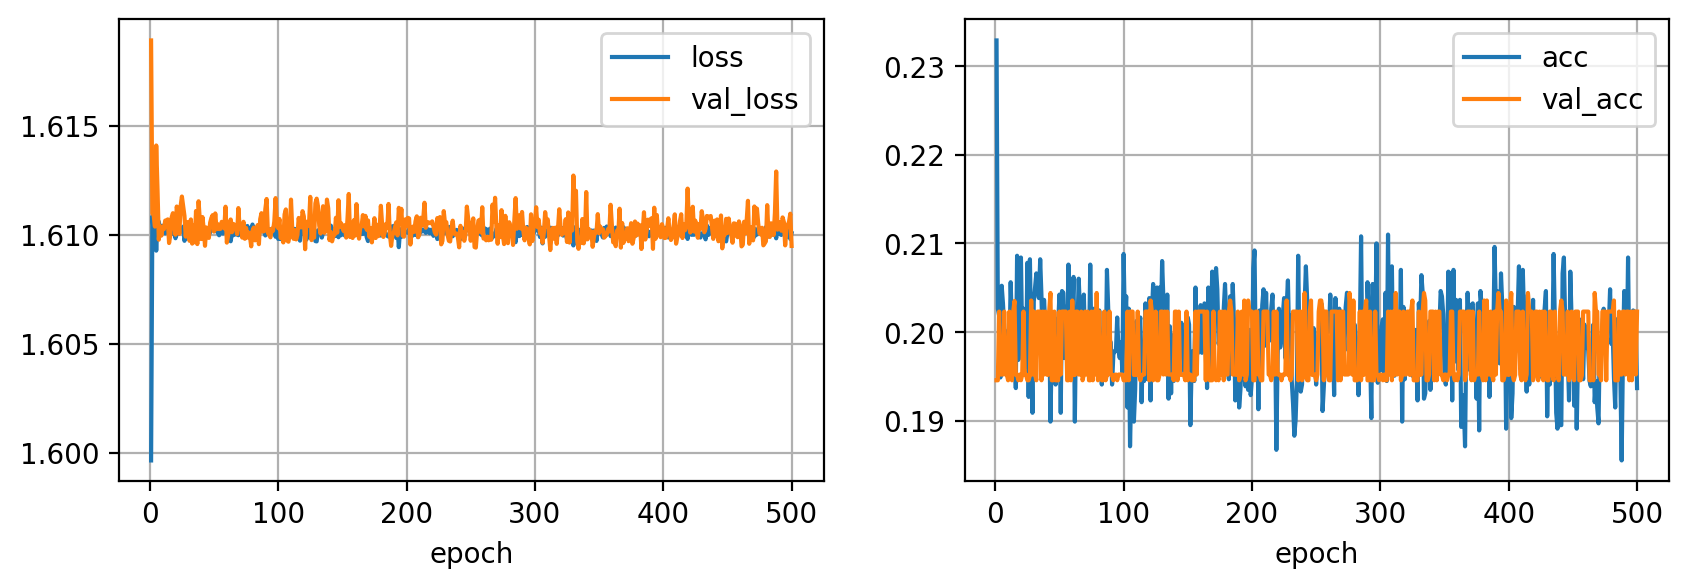

In [ ]:
import pandas as pd

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Como podemos observar de las curvas de entrenamiento, las métricas para el conjunto de datos de entrenamiento van mejorando epoch tras epoch, sin embargo las métricas de validación rápidamente se estancan y empiezan a empeorar. Esta es la señal clara de que nuestro modelo está sufriendo de overfitting, y en las siguientes secciones veremos diferentes técnicas de regularización, el término técnico utilizado para referirnos a las diferentes técnicas de reducción de overfitting.

##**Regularización L2**

Una técnica re regularización muy utilizada es la regularización L2. Esta técnica consiste en restringir la magnitud de los pesos de la red neuronal forzándolos a ser valores pequeños. A efectos prácticos, la regularización L2 se implementa como un término extra en la función de pérdida

In [ ]:
model = build_model()
hist = fit(model, dataloader, weight_decay=0.01)

Epoch 10/500 loss 1.61027 acc 0.20721 val_loss 1.61017 val_acc 0.19455
Epoch 20/500 loss 1.61001 acc 0.19666 val_loss 1.61010 val_acc 0.19520
Epoch 30/500 loss 1.60913 acc 0.21596 val_loss 1.61177 val_acc 0.20230
Epoch 40/500 loss 1.61004 acc 0.19666 val_loss 1.61099 val_acc 0.19455
Epoch 50/500 loss 1.60998 acc 0.20104 val_loss 1.61012 val_acc 0.19455
Epoch 60/500 loss 1.60974 acc 0.19467 val_loss 1.61177 val_acc 0.20230
Epoch 70/500 loss 1.61040 acc 0.19546 val_loss 1.61006 val_acc 0.20230
Epoch 80/500 loss 1.60997 acc 0.20721 val_loss 1.61070 val_acc 0.19520
Epoch 90/500 loss 1.61027 acc 0.19785 val_loss 1.61024 val_acc 0.19520
Epoch 100/500 loss 1.60991 acc 0.20581 val_loss 1.60962 val_acc 0.20230
Epoch 110/500 loss 1.61000 acc 0.20024 val_loss 1.61139 val_acc 0.20230
Epoch 120/500 loss 1.61012 acc 0.19885 val_loss 1.61049 val_acc 0.20230
Epoch 130/500 loss 1.61020 acc 0.19427 val_loss 1.61021 val_acc 0.19520
Epoch 140/500 loss 1.60966 acc 0.20243 val_loss 1.61095 val_acc 0.19455
E

Vemos que el entranamiento no baja el error por los epochs por lo que se necesita probar con mas numeros de epochs. con 500 epoch vemos que no mejora, el loss permanece con valores en su entorno d rango.

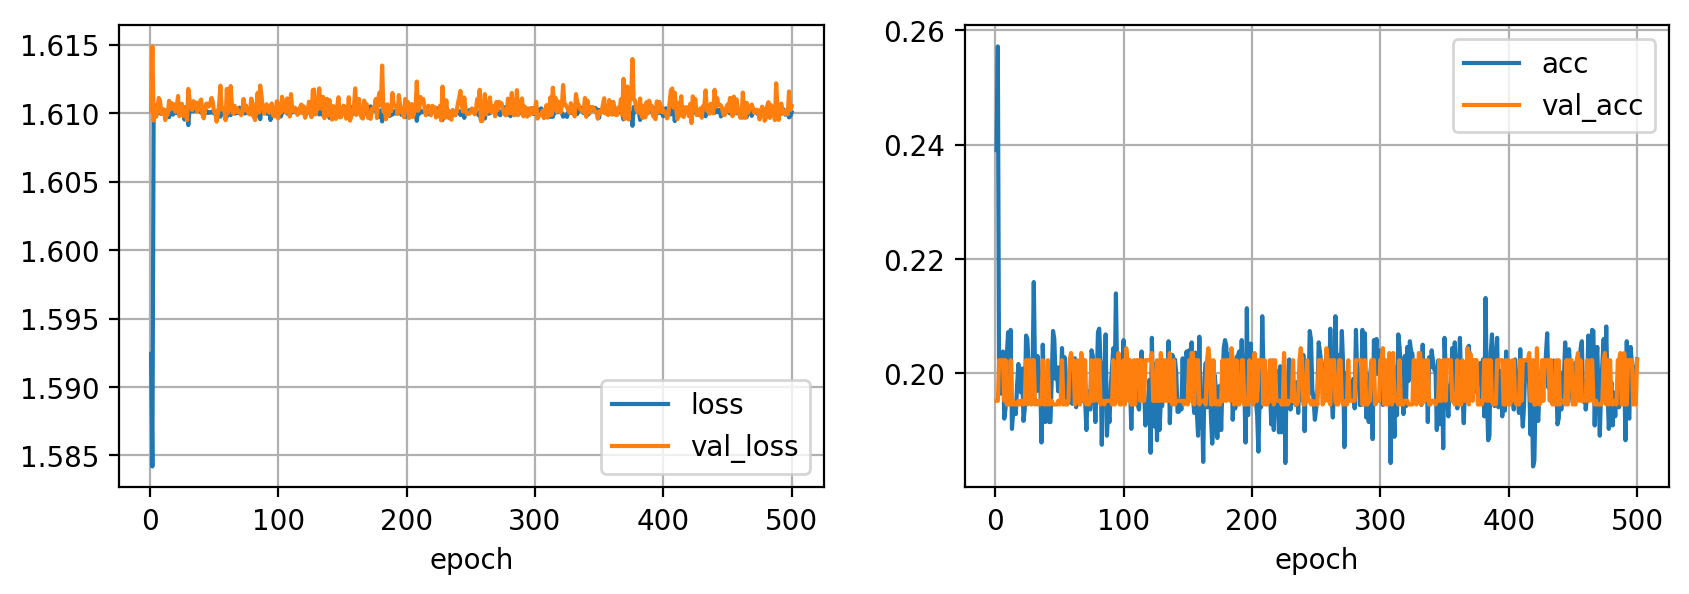

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Como se puede observar ahora las curvas de entrenamiento y validación están más próximas, por lo que hemos disminuido el overfitting. Es importante remarcar que reducir el overfitting no implica mejorar las métricas.

##Early Stopping

Otra técnica muy utilizada para regularizar un modelo es el early stopping. Esta técnica consiste en llevar un registro de las métricas de validación durante el entrenamiento, guardar los pesos del modelo cada vez que mejoramos las mejores métricas obtenidas y, una vez terminado el entrenamiento, cargar los mejores pesos en vez de quedarnos con los últimos. De forma opcional también podemos detener el entrenamiento si no mejoramos nuestras métricas durante un número determinado de epochs seguidas, lo cual puede traducirse en un ahorro de tiempo y cómputo.

In [ ]:
def fit(model, dataloader, epochs=200, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [ ]:
model = build_model()
hist = fit(model, dataloader, early_stopping=20)

Mejor modelo guardado con acc 0.19520 en epoch 1
Mejor modelo guardado con acc 0.20235 en epoch 4
Epoch 10/200 loss 1.61031 acc 0.19885 val_loss 1.61037 val_acc 0.20230
Epoch 20/200 loss 1.61031 acc 0.20004 val_loss 1.60993 val_acc 0.19520
Entrenamiento detenido en epoch 24 por no mejorar en 20 epochs seguidas


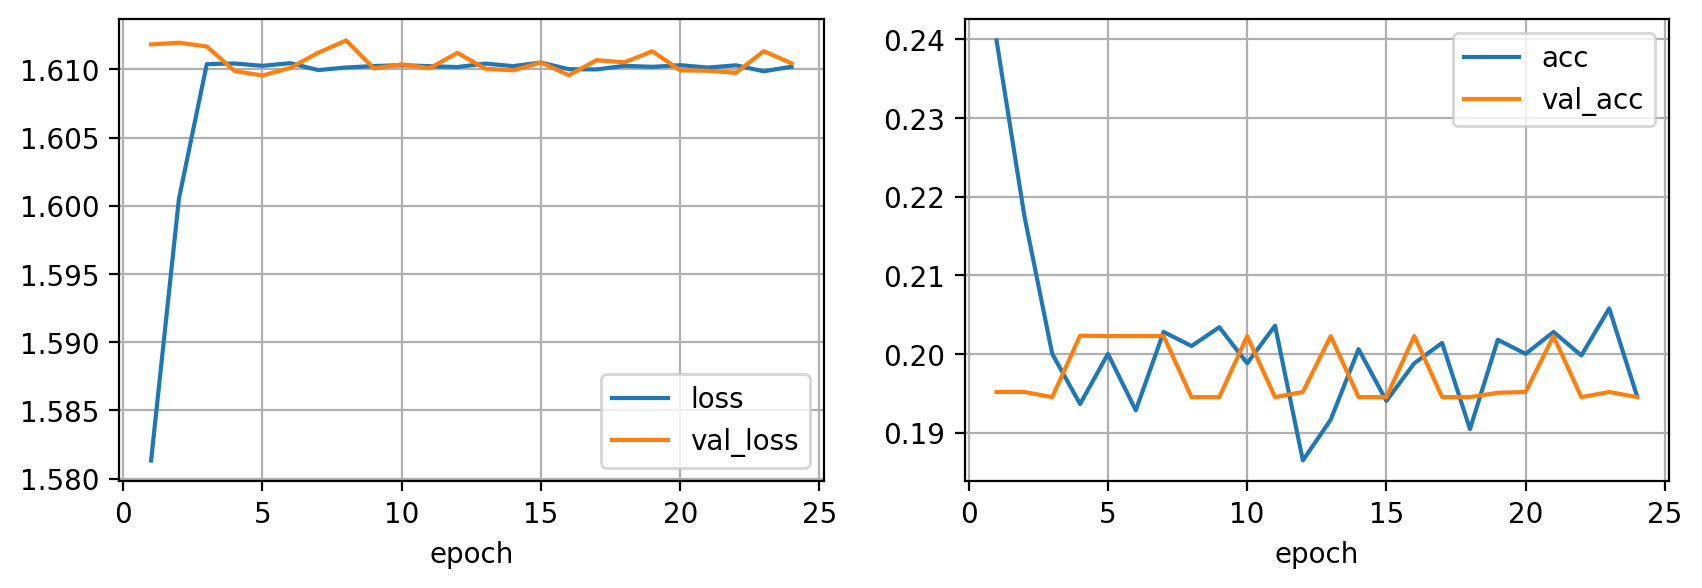

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Si comparas esta figura con la primera, podrás observar que si seguimos entrenando más epochs no vamos a encontrar un modelo mejor, por lo tanto no es necesario seguir entrenando ya que en este punto ya hemos encontrado el mejor modelo posible dadas las circunstancias. Early stopping es una técnica muy sencilla y efectiva, por lo que es recomendable utilizarla siempre.

##Dropout

Otra técnica muy popular para reducir el overfitting es el uso de Dropout. Esta técnica se implementa como una capa extra en nuestra red neuronal cuyo objetivo es, durante el entrenamiento, "apagar" de manera aleatoria algunas neuronas de manera que forzaremos a nuestro modelo a aprender diferentes caminos dentro de la arquitectura para representar los mismos datos.

In [ ]:
def build_model(D_in=50*50*3, H=50, D_out=5, p=0):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, D_out)
    ) #.cuda()

In [ ]:
model = build_model(p=0.5)
hist = fit(model, dataloader)

Mejor modelo guardado con acc 0.19455 en epoch 1
Mejor modelo guardado con acc 0.19520 en epoch 2
Mejor modelo guardado con acc 0.20230 en epoch 8
Epoch 10/200 loss 1.61013 acc 0.19128 val_loss 1.61137 val_acc 0.19455
Epoch 20/200 loss 1.61028 acc 0.20004 val_loss 1.61092 val_acc 0.19520
Mejor modelo guardado con acc 0.20440 en epoch 26
Epoch 30/200 loss 1.60995 acc 0.20283 val_loss 1.61010 val_acc 0.20230
Epoch 40/200 loss 1.61026 acc 0.19785 val_loss 1.60978 val_acc 0.19520
Epoch 50/200 loss 1.61017 acc 0.19964 val_loss 1.61120 val_acc 0.19520
Epoch 60/200 loss 1.61013 acc 0.20223 val_loss 1.61038 val_acc 0.19520
Epoch 70/200 loss 1.61013 acc 0.19785 val_loss 1.61046 val_acc 0.19455
Epoch 80/200 loss 1.61018 acc 0.19765 val_loss 1.60983 val_acc 0.20230
Epoch 90/200 loss 1.61018 acc 0.19705 val_loss 1.61051 val_acc 0.19520
Epoch 100/200 loss 1.61008 acc 0.19924 val_loss 1.61031 val_acc 0.19520
Epoch 110/200 loss 1.61012 acc 0.20462 val_loss 1.61023 val_acc 0.19520
Epoch 120/200 loss 1

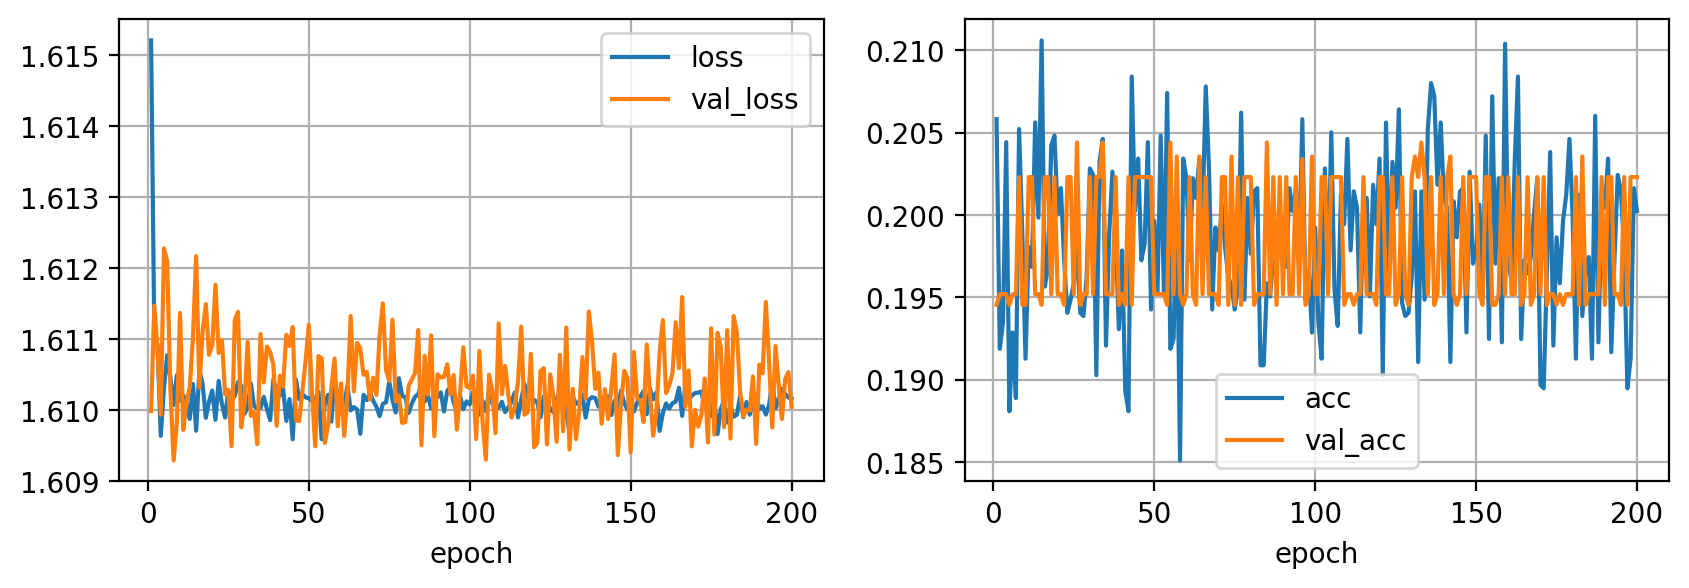

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

De nuevo observamos que las curvas de entrenamiento ya no presentan overfitting. Puedes jugar con la probabilidad de Dropout para controlar su efecto en el resultado final. De nuevo, date cuenta que reducir el overfitting no implica necesariamente que nuestro modelo tenga mejores prestaciones, simplemente estamos forzando al modelo a no "aprender de memoria" el dataset de entrenamiento.

## Usar más datos

La mejor manera de reducir el overfitting es usando más datos. Esto es un hecho obvio, pero no sencillo de conseguir ya que obtener un mayor dataset no es siempre factible y normalmente ya utilizamos todos los datos a nuestra disposición. Sin embargo, a diferencia del resto de estrategias presentadas hasta ahora, ésta no solo reducirá el overfitting si no que también mejorará las prestaciones de nuestro modelo.

In [ ]:
# ahora si que usamos todos los datos

dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 20000)

In [ ]:
model = build_model()
hist = fit(model, dataloader, early_stopping=10)

Mejor modelo guardado con acc 0.20440 en epoch 1
Epoch 10/200 loss 1.61019 acc 0.19800 val_loss 1.60963 val_acc 0.19520
Entrenamiento detenido en epoch 11 por no mejorar en 10 epochs seguidas


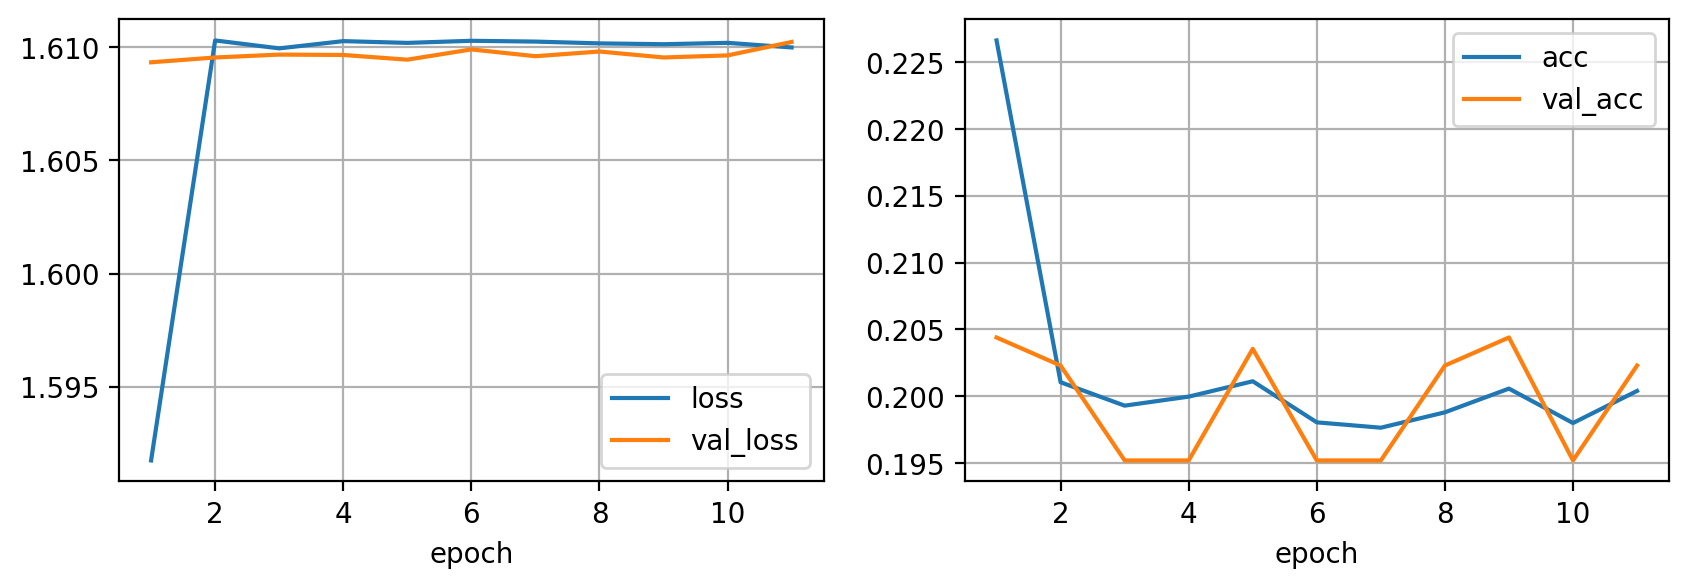

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Como puedes observar la precisión de nuestro modelo ha aumentado considerablemente gracias al uso de más datos. De esta manera aprovechamos más capacidad del modelo.

##APLICANDO Data Augmentation

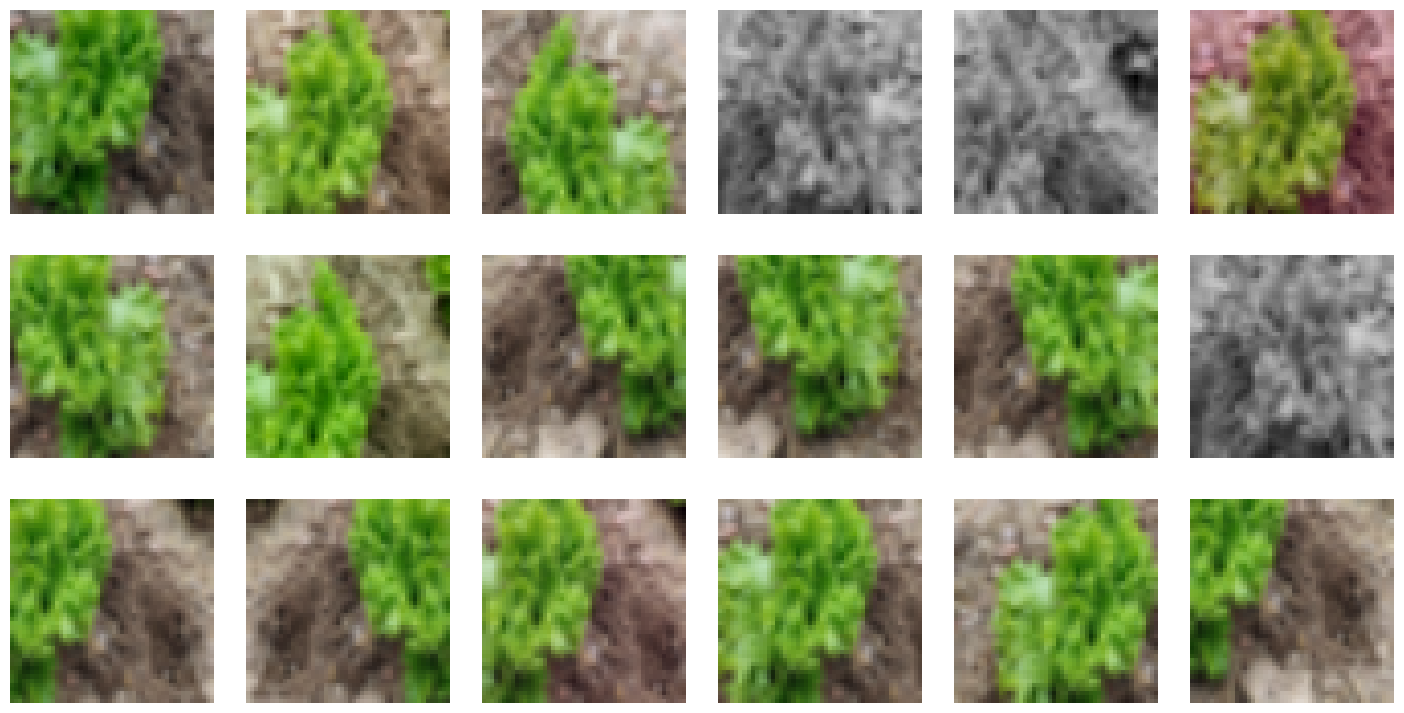

In [ ]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trans = Compose([
    RandomCrop(32,32),
    Resize(50, 50),
    HorizontalFlip(),
    OneOf([
        ToGray(p=0.2),
        RGBShift(p=0.3)
    ])
])

idx = 100
r, c = 3, 6
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        ix = c*row + col
        plt.subplot(r, c, ix + 1)
        img, label = trainset_[idx]
        # apply transformation
        img = trans(image=np.array(img))["image"]
        plt.imshow(img)
        plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

En la figura anterior estás viendo un única muestra de nuestro dataset a la cual le hemos aplicado una serie de transformaciones que han alterado su apariencia sin modificar su etiqueta. Aplicando estas transformaciones aleatorias a cada muestra antes de dársela a la red neuronal obligará a nuestro a modelo a generalizar mucho más, reduciendo el overfitting.

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        img = self.X[ix]
        if self.trans:
            img = self.trans(image=img)["image"]
        img = torch.from_numpy(img / 255.).float().view(-1) #.cuda().view(-1) # Correct the typo: 'vie' to 'view'
        label = torch.tensor(self.Y[ix]).long() #.cuda()
        return img, label

dataset = {
    'train': Dataset(X_train, y_train, trans=trans),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 20000)

In [ ]:
model = build_model()
hist = fit(model, dataloader)

Mejor modelo guardado con acc 0.41835 en epoch 1
Mejor modelo guardado con acc 0.47280 en epoch 2
Mejor modelo guardado con acc 0.47750 en epoch 7
Mejor modelo guardado con acc 0.48075 en epoch 8
Mejor modelo guardado con acc 0.50500 en epoch 10
Epoch 10/200 loss 1.39435 acc 0.38955 val_loss 1.19062 val_acc 0.50500
Epoch 20/200 loss 1.43082 acc 0.36888 val_loss 1.32226 val_acc 0.49960
Mejor modelo guardado con acc 0.64500 en epoch 21
Epoch 30/200 loss 1.32336 acc 0.45290 val_loss 1.22600 val_acc 0.48825
Epoch 40/200 loss 1.42847 acc 0.36402 val_loss 1.25863 val_acc 0.46695
Epoch 50/200 loss 1.34412 acc 0.44072 val_loss 1.20123 val_acc 0.49765
Epoch 60/200 loss 1.33888 acc 0.44127 val_loss 1.10068 val_acc 0.57730
Epoch 70/200 loss 1.32766 acc 0.44527 val_loss 1.02569 val_acc 0.63615
Epoch 80/200 loss 1.35615 acc 0.42442 val_loss 0.99810 val_acc 0.59895
Epoch 90/200 loss 1.34788 acc 0.43495 val_loss 1.02867 val_acc 0.61720
Epoch 100/200 loss 1.42664 acc 0.35692 val_loss 1.27480 val_acc 0

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

El uso de data augmentation requerirá de ciclos de entrenamiento más largos para poder aprovechar toda la capacidad que las transformaciones nos ofrecen. Una característica interesante de esta técnica es que podemos conseguir que las curvas de aprendizaje de validación estén por encima de las de entrenamiento, indicando que nuestro modelo realmente trabaja mejor en datos no vistos (lo cual no significa necesariamente que el modelo sea mejor, en este caso por ejemplo nuestras métricas no son tan buenas como en el caso anterior).

##CONCLUSIÓN

##===============================================================================================

#**3. APLICANDO OPTIMIZACIÓN**

En este post vamos a ver algunas técnicas que podemos aplicar durante el entrenamiento de nuestras redes neuronales para acelerar el proceso de optimización y, potencialmente, obtener mejores resultados de los que hemos sido capaces de obtener hasta ahora. Compararemos estas técnicas en el mismo problema utilizado en el post anterior, la clasificación de imágenes con el dataset

In [ ]:
# MOSTRAMOS LOS DATASET PREPROCESADOS

import copy
trainsetOp = copy.deepcopy(trainset)
testsetOp = copy.deepcopy(testset)

# Nombramos los nombres de las clases que tendran nuestro dataset, en tipo de labels para las plantas
classes = ('Acelga', 'Cebolla', 'Espinaca', 'Lechuga', 'Toronjil')

In [ ]:
import numpy as np

train_images = np.array([np.array(img) for img, label in trainsetOp])
X_test = np.array([np.array(img) for img, label in testsetOp])

train_labels = np.array([label for img, label in trainsetOp])
y_test = np.array([label for img, label in testsetOp])

X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]

X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((40000, 50, 50, 3), (20000, 50, 50, 3), (15000, 50, 50, 3), (5000, 50, 50, 3))

In [ ]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().view(-1, 50*50*3) #.cuda()
        self.Y = torch.from_numpy(Y).long()#.cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=100, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 20000)

In [ ]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=50*50*3, H=50, D_out=5):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    )#.cuda()

def fit(model, dataloader, optimizer, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

##Optimizadores

Hasta este punto, hemos optimizado siempre nuestras redes neuronales con el algoritmo de stochastic gradient descent

##Momentum

La primera mejora que podemos hacer sobre el algoritmo SGD es añadir momentum. De la misma manera que una pelota rodando por una superficie inclinada acelera poco a poco debido a la fuerza de la gravedad (a esto se le llama ganar momentum) podemos hacer que nuestros pasos de descenso por gradiente sean más grandes si el signo del gradiente es el mismo durante updates consecutivos

In [ ]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_momentum = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.33775 en epoch 1
Mejor modelo guardado con acc 0.55575 en epoch 2
Mejor modelo guardado con acc 0.61325 en epoch 3
Mejor modelo guardado con acc 0.63335 en epoch 4
Mejor modelo guardado con acc 0.68530 en epoch 6
Mejor modelo guardado con acc 0.74005 en epoch 7
Mejor modelo guardado con acc 0.74850 en epoch 10
Epoch 10/100 loss 0.59664 acc 0.76831 val_loss 0.61945 val_acc 0.74850
Mejor modelo guardado con acc 0.76450 en epoch 12
Mejor modelo guardado con acc 0.77850 en epoch 14
Mejor modelo guardado con acc 0.80095 en epoch 16
Mejor modelo guardado con acc 0.82150 en epoch 18
Epoch 20/100 loss 0.40758 acc 0.84494 val_loss 0.57264 val_acc 0.77705
Mejor modelo guardado con acc 0.83800 en epoch 21
Mejor modelo guardado con acc 0.84645 en epoch 26
Epoch 30/100 loss 0.21239 acc 0.92715 val_loss 0.42703 val_acc 0.84060
Mejor modelo guardado con acc 0.85190 en epoch 31
Mejor modelo guardado con acc 0.85815 en epoch 32
Mejor modelo guardado con acc 0.85820 en ep

##RMSProp

El algoritmo del descenso por gradiente funciona intentando descender rápidamente en la dirección en la que el gradiente es mayor. Sin embargo, esta dirección no tiene porqué ser siempre la que indica el camino hacia el óptimo global. El algoritmo de optimización RMSProp intenta tener este factor en cuenta escalando el gradiente en la dimensión con mayor pendiente

In [ ]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
hist_rms = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.24250 en epoch 1
Mejor modelo guardado con acc 0.52120 en epoch 2
Mejor modelo guardado con acc 0.57990 en epoch 5
Mejor modelo guardado con acc 0.65545 en epoch 7
Mejor modelo guardado con acc 0.76965 en epoch 9
Epoch 10/100 loss 0.58600 acc 0.76553 val_loss 1.15619 val_acc 0.63130
Mejor modelo guardado con acc 0.78070 en epoch 13
Mejor modelo guardado con acc 0.80235 en epoch 20
Epoch 20/100 loss 0.40766 acc 0.85032 val_loss 0.45906 val_acc 0.80235
Mejor modelo guardado con acc 0.85900 en epoch 23
Mejor modelo guardado con acc 0.86510 en epoch 26
Mejor modelo guardado con acc 0.88850 en epoch 30
Epoch 30/100 loss 0.28955 acc 0.89749 val_loss 0.30588 val_acc 0.88850
Epoch 40/100 loss 0.20254 acc 0.92536 val_loss 1.16564 val_acc 0.65950
Mejor modelo guardado con acc 0.89070 en epoch 47
Mejor modelo guardado con acc 0.89455 en epoch 48
Epoch 50/100 loss 0.16779 acc 0.94506 val_loss 0.30056 val_acc 0.89335
Mejor modelo guardado con acc 0.90225 en epoch 51


##Adam

Adam combina las ideas de momentum y RMSProp, y es la opción elegida por defecto por la mayoría de desarrolladores.

In [ ]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist_adam = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.53420 en epoch 1
Mejor modelo guardado con acc 0.61935 en epoch 2
Mejor modelo guardado con acc 0.63425 en epoch 3
Mejor modelo guardado con acc 0.72525 en epoch 4
Mejor modelo guardado con acc 0.72610 en epoch 5
Mejor modelo guardado con acc 0.75760 en epoch 6
Mejor modelo guardado con acc 0.76730 en epoch 7
Mejor modelo guardado con acc 0.79200 en epoch 9
Mejor modelo guardado con acc 0.79235 en epoch 10
Epoch 10/100 loss 0.44328 acc 0.82126 val_loss 0.52759 val_acc 0.79235
Mejor modelo guardado con acc 0.80575 en epoch 11
Mejor modelo guardado con acc 0.80995 en epoch 12
Mejor modelo guardado con acc 0.81535 en epoch 13
Mejor modelo guardado con acc 0.82655 en epoch 14
Mejor modelo guardado con acc 0.84900 en epoch 17
Mejor modelo guardado con acc 0.87205 en epoch 18
Epoch 20/100 loss 0.24478 acc 0.90924 val_loss 0.41394 val_acc 0.84185
Mejor modelo guardado con acc 0.88000 en epoch 26
Mejor modelo guardado con acc 0.88605 en epoch 29
Epoch 30/100 los

##Sin optimizador


In [ ]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
hist_sgd = fit(model, dataloader, optimizer, early_stopping=10)

Mejor modelo guardado con acc 0.20700 en epoch 1
Mejor modelo guardado con acc 0.23575 en epoch 2
Mejor modelo guardado con acc 0.29125 en epoch 3
Mejor modelo guardado con acc 0.33835 en epoch 4
Mejor modelo guardado con acc 0.37370 en epoch 6
Mejor modelo guardado con acc 0.38790 en epoch 7
Mejor modelo guardado con acc 0.39440 en epoch 8
Mejor modelo guardado con acc 0.42090 en epoch 9
Epoch 10/100 loss 1.42435 acc 0.41242 val_loss 1.41175 val_acc 0.39430
Mejor modelo guardado con acc 0.43530 en epoch 12
Mejor modelo guardado con acc 0.46060 en epoch 13
Mejor modelo guardado con acc 0.47295 en epoch 14
Mejor modelo guardado con acc 0.48500 en epoch 15
Mejor modelo guardado con acc 0.50500 en epoch 16
Mejor modelo guardado con acc 0.52345 en epoch 19
Epoch 20/100 loss 1.15693 acc 0.53404 val_loss 1.15363 val_acc 0.50340
Mejor modelo guardado con acc 0.55290 en epoch 21
Mejor modelo guardado con acc 0.56980 en epoch 23
Mejor modelo guardado con acc 0.58240 en epoch 24
Mejor modelo gua

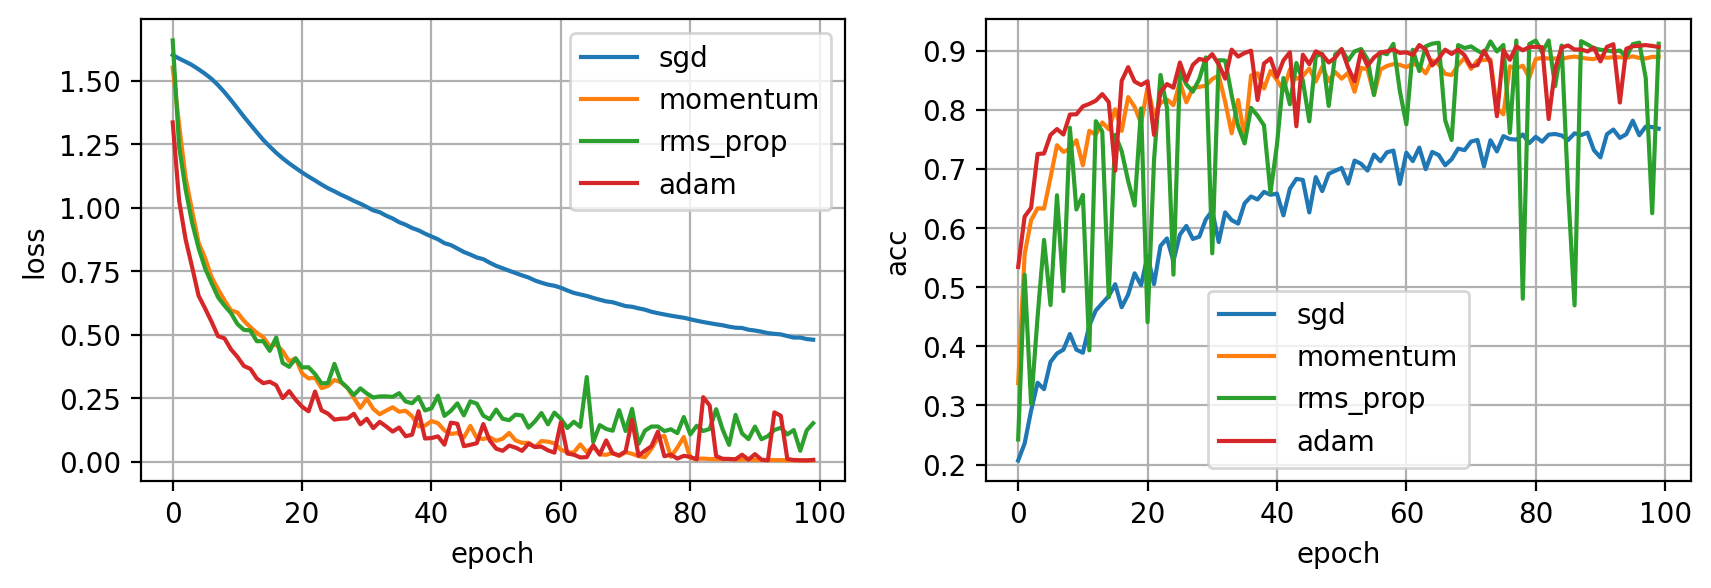

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_sgd['loss'], label="sgd")
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_rms['loss'], label="rms_prop")
ax.plot(hist_adam['loss'], label="adam")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_sgd['val_acc'], label="sgd")
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_rms['val_acc'], label="rms_prop")
ax.plot(hist_adam['val_acc'], label="adam")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Como puedes ver, las variantes de SGD son capaces de converger mucho más rápido. Aún así, si le damos suficiente tiempo, SGD es capaz de llegar a los mismos resultados, e incluso superarlos. Existen muchos otros optimizadores, sin embargo los vistos aquí son los más comunes.

##Learning Rate Scheduling

Otra técninca muy utilizada para acelerar el proceso de entrenamiento de una red neuronal es el learning rate scheduling y consiste en ir variando el factor de aprendizaje durante el entrenamiento en vez de utilizar un valor fijo. Un valor alto del learning rate nos puede dar una ventaja en las fases iniciales del entrenamiento, en las que queremos acercarnos al punto óptimo de manera rápida. Aun así, no nos permitirá llegar al mejor valor posible ya que se quedará oscilando alrededor. En este punto, un learning rate pequeño nos permitiría acercarnos mucho más al valor óptimo, pero tardaría mucho en llegar en primer lugar.

In [ ]:
def fit(model, dataloader, optimizer, scheduler=None, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        if scheduler:
            scheduler.step()
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [ ]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# multiplica el lr por 0.1 cada 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1)

hist_step = fit(model, dataloader, optimizer, scheduler, epochs=30)

Mejor modelo guardado con acc 0.56975 en epoch 1
Mejor modelo guardado con acc 0.58795 en epoch 4
Mejor modelo guardado con acc 0.75045 en epoch 5
Mejor modelo guardado con acc 0.78330 en epoch 8
Mejor modelo guardado con acc 0.79050 en epoch 10
Epoch 10/30 loss 0.53078 acc 0.79538 val_loss 0.52274 val_acc 0.79050 lr 0.01000
Mejor modelo guardado con acc 0.85510 en epoch 11
Mejor modelo guardado con acc 0.86335 en epoch 13
Mejor modelo guardado con acc 0.86640 en epoch 14
Mejor modelo guardado con acc 0.86685 en epoch 16
Mejor modelo guardado con acc 0.86775 en epoch 17
Mejor modelo guardado con acc 0.87035 en epoch 18
Epoch 20/30 loss 0.21203 acc 0.92297 val_loss 0.35191 val_acc 0.86780 lr 0.00100
Mejor modelo guardado con acc 0.87355 en epoch 21
Mejor modelo guardado con acc 0.87505 en epoch 22
Epoch 30/30 loss 0.18933 acc 0.93511 val_loss 0.33475 val_acc 0.87405 lr 0.00010


In [ ]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# aumenta el lr por 5 epochs, luego decrece
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=5, step_size_down=25)

hist_cycle = fit(model, dataloader, optimizer, scheduler, epochs=30)

Mejor modelo guardado con acc 0.20670 en epoch 1
Mejor modelo guardado con acc 0.39715 en epoch 2
Mejor modelo guardado con acc 0.57020 en epoch 3
Mejor modelo guardado con acc 0.64525 en epoch 4
Mejor modelo guardado con acc 0.76320 en epoch 7
Mejor modelo guardado con acc 0.79250 en epoch 10
Epoch 10/30 loss 0.50910 acc 0.79877 val_loss 0.50513 val_acc 0.79250 lr 0.00842
Mejor modelo guardado con acc 0.79745 en epoch 11
Mejor modelo guardado con acc 0.80005 en epoch 14
Mejor modelo guardado con acc 0.81595 en epoch 16
Mejor modelo guardado con acc 0.85785 en epoch 17
Mejor modelo guardado con acc 0.85800 en epoch 19
Mejor modelo guardado con acc 0.87595 en epoch 20
Epoch 20/30 loss 0.21062 acc 0.92158 val_loss 0.32754 val_acc 0.87595 lr 0.00446
Mejor modelo guardado con acc 0.89560 en epoch 25
Mejor modelo guardado con acc 0.90005 en epoch 26
Mejor modelo guardado con acc 0.90140 en epoch 27
Mejor modelo guardado con acc 0.90275 en epoch 30
Epoch 30/30 loss 0.06837 acc 0.98069 val_lo

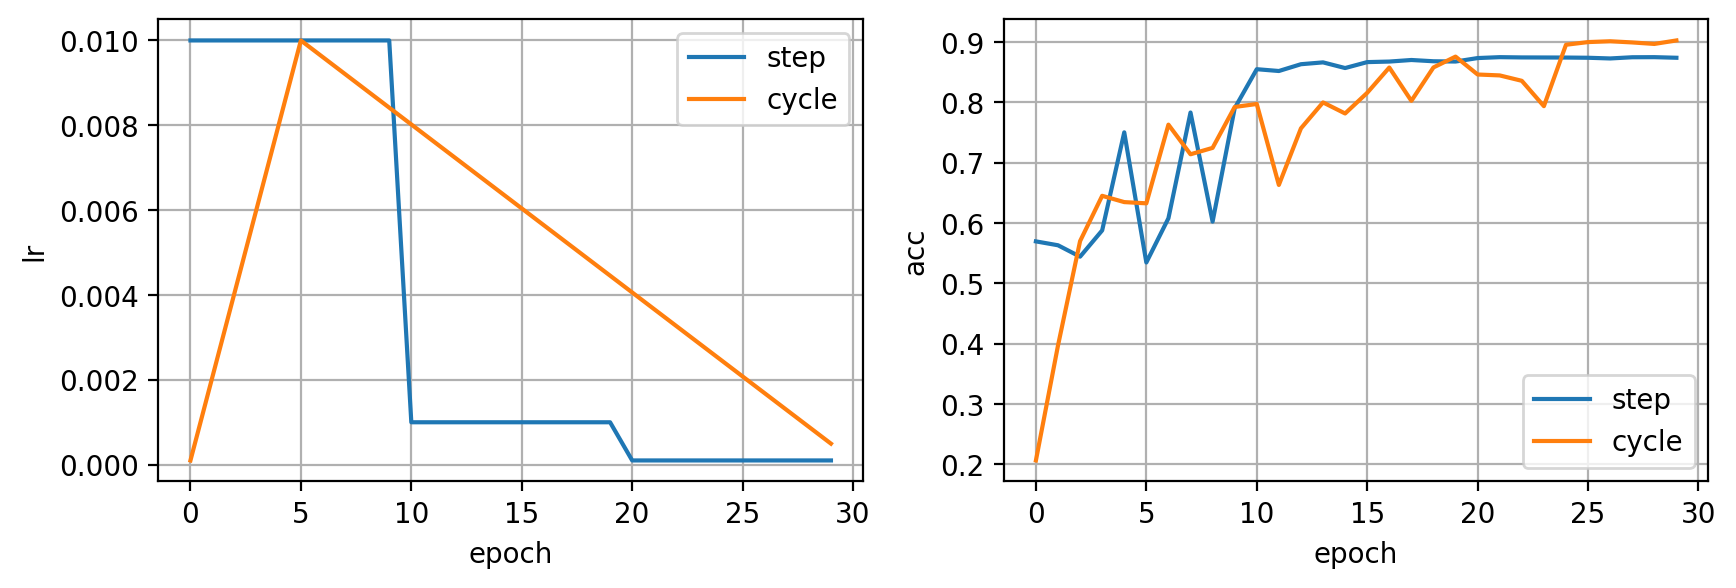

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_step['lr'], label="step")
ax.plot(hist_cycle['lr'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('lr')
ax = plt.subplot(122)
ax.plot(hist_step['val_acc'], label="step")
ax.plot(hist_cycle['val_acc'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

##Normalización

Otra técnica muy importante para acelerar el entrenamiento consiste en normalizar nuestros datos. Esto es algo de lo que ya hemos hablado en posts anteriores, y en este mismo post puedes ver como al principio de todo hemos dividido nuestras imágenes entre 255 de manera que los valores presentes en los tensores que nuestra red neuronal usa como entradas estén normalizados entre 0 y 1. Otra normalización popular, cuando trabajamos con imágenes, consiste en calcular el valor medio y desviación estándar de nuestro dataset, y normalizar las imágenes para que tengan media 0 y desviación estándar 1.

In [ ]:
import numpy as np

mean = (train_images / 255).mean(axis=(0, 1, 2))
std = (train_images / 255).std(axis=(0, 1, 2))

mean, std

In [ ]:
train_images_norm = ((train_images / 255) - mean) / std
train_images_norm.mean(axis=(0, 1, 2)), train_images_norm.std(axis=(0, 1, 2))

In [ ]:
X_test_norm = np.array([(np.array(img)/255. - mean) / std for img, label in testset])

X_train_norm, X_val_norm, X_subset_norm = train_images_norm[:40000], train_images_norm[40000:], train_images_norm[:5000]

X_train_norm.shape, X_val_norm.shape, X_test_norm.shape, X_subset_norm.shape

In [ ]:
dataset_norm = {
    'train': Dataset(X_subset_norm, y_subset),
    'val': Dataset(X_val_norm, y_val),
}

dataloader_norm = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset_norm['train']), len(dataset_norm['val'])

In [ ]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_norm = fit(model, dataloader_norm, optimizer)

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_norm['loss'], label="momentum + norm")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_norm['val_acc'], label="momentum + norm")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

En este caso, el efecto de la normalización no es considerable (al trabajar con imágenes éste suele ser el caso).

##Batch Normalization

Otra forma de normalización muy importante que puede acelerar de manera dramática el entrenamiento es el batch norm. Podemos añadir esta capa en nuestras redes y su objetivo será el de normalizar sus entradas para que tengan media cero y desviación estándar 1. Además, aprenderá unos parámetros que le permitirán escalar y mover estos valores normalizados para mejorar sus representación, facilitando a la red neuronal la tarea de clasificación.



In [ ]:
def build_model(D_in=50*50*3, H=50, D_out=5):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [ ]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_bn = fit(model, dataloader, optimizer)

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_bn['loss'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_bn['val_acc'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Como puedes observar, la introducción de la capa Batch Norm acelera muchísimo el entrenamiento, resultando en una reducción de la función de pérdida mucho más rápida (haciendo que nuestro modelo haga overfitting mucho más pronto). Combinando esta capa con alguna forma de regularización, como por ejemplo data augmentation y early stopping, obtendremos buenos modelos capaces de generalizar de manera rápida.

##=======================================================================================================

##**Pytorch - Guardando y Exportando Modelos**

En posts anteriores hemos aprendido a utilizar la librería Pytorch, viendo los conceptos baśicos, cómo diseñar y entrenar redes neuroanles y a manejar datasets de manera eficiente. Sin embargo, entrenar un modelo es solo parte del trabajo. Una vez tenemos nuestra red lista necesitamos poder guardarla en un archivo, o exportarla, para luego importarla en nuestras aplicaciones y ponerla a trabajar en un entorno de producción. En este post vamos a ver las diferentes opciones que Pytorch nos ofrece a a la hora de exportar modelos.

##GUARDANDO LOS MODELOS


###Guardando los parámetros

La primera opción consiste en guardar sólo los parámetros de la red. Para ello, Pytorch nos permite guardar el state_dict del modelo, un dict de Python que contiene una relación directa entre todas las capas con parámetros de la red y sus valores.

En el siguiente código, utilizado ya en este post, entrenamos un modelo simple con el dataset MNIST y, una vez entrenado, guardamos el state_dict del modelo.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Definición de la clase PlantasDataset
class PlantasDataset(Dataset):
    def __init__(self, archivo_dataset, transform=None):
        self.imagenes, self.etiquetas = torch.load(archivo_dataset)
        self.transform = transform

    def __len__(self):
        return len(self.etiquetas)

    def __getitem__(self, idx):
        imagen = self.imagenes[idx]
        etiqueta = self.etiquetas[idx]

        if self.transform:
            imagen = self.transform(imagen)

        return imagen, etiqueta


# Definimos los transformadores de datos si es necesario
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalización si es necesario
])

# Cargar tus datasets previamente guardados
trainset = PlantasDataset('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_train.pt')
testset = PlantasDataset('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_test.pt')

# Verificar el número de ejemplos
print("Número de ejemplos en el conjunto de entrenamiento:", len(trainset))
print("Número de ejemplos en el conjunto de prueba:", len(testset))


Número de ejemplos en el conjunto de entrenamiento: 60000
Número de ejemplos en el conjunto de prueba: 15000


In [ ]:
trainset

In [ ]:
# Nombramos los nombres de las clases que tendran nuestro dataset, en tipo de labels para las plantas
classes = ('Acelga', 'Cebolla', 'Espinaca', 'Lechuga', 'Toronjil')

Dimensiones de la imagen: torch.Size([3, 50, 50])
Valores mínimos y máximos: tensor(41.) tensor(244.)


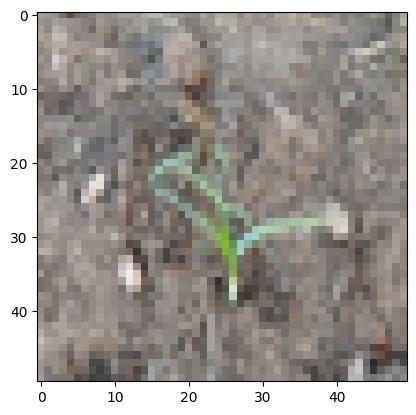

In [ ]:
# Extraer una imagen del dataset
img, label = trainset[0]

# Verificar las dimensiones de la imagen
print("Dimensiones de la imagen:", img.shape)

# Verificar el rango de valores en la imagen
print("Valores mínimos y máximos:", img.min(), img.max())

# Normalizar la imagen para que sus valores estén entre [0, 1]
img = img / 255.0

# Permutar dimensiones y mostrar la imagen
img = img.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.show()

In [ ]:
# Crear los DataLoader a partir de los datasets de entrenamiento y prueba
dataloader = {
    'train': DataLoader(trainset, batch_size=500, shuffle=True, pin_memory=True),
    'test': DataLoader(testset, batch_size=500, shuffle=False, pin_memory=True)
}

In [ ]:

# Definimos el modelo
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

class CNN(torch.nn.Module):
    def __init__(self, n_channels=3, n_outputs=5):  # n_channels cambiado a 3 para imágenes RGB, n_outputs cambiado a 5 para 5 etiquetas
        super().__init__()
        self.conv1 = block(n_channels, 64)
        self.conv2 = block(64, 128)
        self.fc = torch.nn.Linear(128*12*12, n_outputs)  # Ajustar las dimensiones aquí basadas en el tamaño de la imagen después de las convoluciones

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [ ]:
# Entrenamos el modelo
def fit(model, dataloader, epochs=3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
model = CNN()
fit(model, dataloader)

val_loss 0.65078 val_acc 0.73693: 100%|██████████| 30/30 [01:36<00:00,  3.20s/it]


Epoch 1/3 loss 8.22221 val_loss 0.65078 acc 0.52818 val_acc 0.73693


val_loss 0.47307 val_acc 0.80847: 100%|██████████| 30/30 [01:38<00:00,  3.30s/it]


Epoch 2/3 loss 0.57949 val_loss 0.47307 acc 0.76757 val_acc 0.80847


val_loss 0.41632 val_acc 0.83520: 100%|██████████| 30/30 [01:38<00:00,  3.27s/it]

Epoch 3/3 loss 0.44300 val_loss 0.41632 acc 0.82453 val_acc 0.83520


In [ ]:
# guardar modelo

PATH = './checkpoint.pt'
torch.save(model.state_dict(), PATH)

Ahora podemos cargar nuestro modelo y utilizarlo normalmente

In [ ]:
# cargar modelo

model.load_state_dict(torch.load(PATH))
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=18432, out_features=5, bias=True)
)

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    model.to(device)
    bar = tqdm(dataloader['test'])
    acc = []
    with torch.no_grad():
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            acc.append((y == torch.argmax(y_hat, axis=1)).sum().item() / len(y))
            bar.set_description(f"acc {np.mean(acc):.5f}")

In [ ]:
evaluate(model, dataloader)

acc 0.83520: 100%|██████████| 30/30 [01:37<00:00,  3.26s/it]


Si bien de esta manera podemos guardar y cargar el modelo de manera eficiente, necesitamos tener un modelo instanciado para poder llamar a la función model.load_state_dict(). Esto significa que necesitaremos la definición de nuestro modelo allá dónde queramos importarlo (lo cual es poco flexible). Alternativamente, Pytorch nos permite guardar el modelo entero, y no solo el state_dict, de la siguiente manera.

In [ ]:
torch.save(model, 'model.pt')

Y podemos cargar y evaluar nuestro modelo así

In [ ]:
model = torch.load('model.pt')
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=18432, out_features=5, bias=True)
)

In [ ]:
evaluate(model, dataloader)

acc 0.83520: 100%|██████████| 30/30 [01:37<00:00,  3.24s/it]


Si bien de esta forma no necesitamos que nuestro modelo esté instanciado, seguimos necesitando su definición. Es por este motivo que la opción anterior es la recomendada, ya que es más eficiente (sólo guardamos los pesos) y también más flexible (podemos guardar otra información además del state_dict de nuestro modelo). Esta opción es ideal para guardar y cargar modelos durante el entrenamiento del mismo, quizás incluso junto al estado del optimizador, de manera que podemos entrenar modelos a partir de estos checkpoints en lugar de empezar de cero cada vez. Otro ejemplo consistiría en guardar el state_dict del modelo durante el entrenamiento solo cuando mejore una métrica determinada y cargar el mejor modelo al final del entrenamiento (que no tiene porqué coincidir con el último).

In [ ]:
def fit(model, dataloader, epochs=5, PATH="./checkpoint.pt"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    best_acc = 0
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        # guardar modelo si es el mejor
        val_acc = np.mean(val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), PATH)
            print(f"Best model saved at epoch {epoch} with val_acc {val_acc:.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
    # cargar el mejor modelo al final del entrenamiento
    model.load_state_dict(torch.load(PATH))

In [ ]:
model = CNN()
fit(model, dataloader)

val_loss 0.49795 val_acc 0.79620: 100%|██████████| 30/30 [01:36<00:00,  3.23s/it]


Best model saved at epoch 1 with val_acc 0.79620
Epoch 1/5 loss 11.93576 val_loss 0.49795 acc 0.57732 val_acc 0.79620


val_loss 0.31663 val_acc 0.87580: 100%|██████████| 30/30 [01:36<00:00,  3.21s/it]


Best model saved at epoch 2 with val_acc 0.87580
Epoch 2/5 loss 0.40555 val_loss 0.31663 acc 0.83888 val_acc 0.87580


val_loss 0.25387 val_acc 0.90213: 100%|██████████| 30/30 [01:36<00:00,  3.23s/it]


Best model saved at epoch 3 with val_acc 0.90213
Epoch 3/5 loss 0.28582 val_loss 0.25387 acc 0.89118 val_acc 0.90213


val_loss 0.16388 val_acc 0.94020: 100%|██████████| 30/30 [01:35<00:00,  3.18s/it]


Best model saved at epoch 4 with val_acc 0.94020
Epoch 4/5 loss 0.21866 val_loss 0.16388 acc 0.91950 val_acc 0.94020


val_loss 0.18027 val_acc 0.93047: 100%|██████████| 30/30 [01:36<00:00,  3.20s/it]

Epoch 5/5 loss 0.16632 val_loss 0.18027 acc 0.93863 val_acc 0.93047


In [ ]:
evaluate(model, dataloader)

acc 0.94020: 100%|██████████| 30/30 [01:36<00:00,  3.21s/it]


Guardar nuestros modelos, ya sea el modelo entero o solo su state_dict, es la forma más directa y sencilla de guardar cualquier modelo que hagamos. Sin embargo, tiene ciertas limitaciones. Por un lado, como ya hemos visto, necesitamos la definición del modelo tanto a la hora de entrar como en producción.

#**Exportando modelos**

##**Torchscript**

In [ ]:
# tracing

x = torch.rand(32, 3, 50, 50)
traced_model = torch.jit.trace(model.cpu(), x)
traced_model.save('model.zip')

In [ ]:
loaded_model = torch.jit.load('model.zip')
evaluate(loaded_model, dataloader)

acc 0.94020: 100%|██████████| 30/30 [01:50<00:00,  3.68s/it]


In [ ]:
# scripting

scripted_model = torch.jit.script(model.cpu())
scripted_model.save('model.zip')

In [ ]:
loaded_model = torch.jit.load('model.zip')
evaluate(loaded_model, dataloader)

acc 0.94020: 100%|██████████| 30/30 [01:39<00:00,  3.33s/it]


Exportar nuestro modelo nos aporta varias ventajas:

- Ahora nuestro modelo puede ejecutarse en cualquier entorno capaz de interpretar la representación intermedia generada por torchscript, independientemente del hardware o software utilizado.
- Nuestro modelo contiene los pesos y la definición de las operaciones, evitando tener que guardar código extra.
- Esta representación intermedia puede ser optimizada de manera independiente, haciendo que nuestros modelos sean más rápidos.

Un consejo a tener en cuenta a la hora de exportar nuestros modelos que nos puede hacer la vida más fácil cuando pongamos nuestros modelos en producción, es incluir cualquier pre- o post-procesado de datos necesarios en el mismo modelo

In [ ]:
class Preprocessing(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        # esperamos un batch de imágenes sin normalizar
        # normalización
        x = (x / 255.)
        x = (x - 0.1307) / 0.3081
        # dimsensiones -> [bs, c, h, w]
        # x = x.unsqueeze(1)
        # en imágenes en color, haríamos un `permute`
        return x

class Postprocessing(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self, x) :
        # devolvemos distribución de probabilidad
        # y clase con mayor probabilidad
        return self.softmax(x), torch.argmax(x, dim=1)

In [ ]:
final_model = torch.nn.Sequential(
    Preprocessing(),
    model.cpu(),
    Postprocessing()
)

scripted_model = torch.jit.script(final_model)
scripted_model.save('model.zip')

Ahora nuestro modelo acepta lotes de imágenes sin normalizar y con las dimensiones más comunes (alto, ancho) y devuelve una distribución de probabilidad. Es nuestro modelo quien se encarga del procesado.

In [ ]:
def script_evaluate(model, dataloader):
    model = torch.jit.load(model)
    model.eval()
    bar = tqdm(dataloader['test'])
    acc = []
    with torch.no_grad():
        for batch in bar:
            X, y = batch
            # desnormalizar
            X = (X*0.3081 + 0.1307)*255
            # quitar dimensión canales
            # X = X.squeeze(1)
            # el modelo pre-procesa
            y_hat, label = model(X)
            acc.append((y == label).sum().item() / len(y))
            bar.set_description(f"acc {np.mean(acc):.5f}")

In [ ]:
script_evaluate("model.zip", dataloader)

acc 0.94020: 100%|██████████| 30/30 [01:52<00:00,  3.74s/it]


#**ONNX**

Si bien ahora nuestro modelo es capaz de ser importado y ejecutado de forma más flexible y eficiente, seguimos limitados por el hecho de necesitar Pytorch (o la librería Torchscript en C++) para ello. Por este motivo, Pytorch nos ofrece una última manera de exportar nuestros modelos a otra forma de representación intermedia conocida como ONNX. Éste es un formato abierto con el espíritu de convertirse en un estándar de representación de redes neuronales.

Así pues, exportar nuestros modelos a formato ONNX nos proporcionará la máxima flexibilidad, permitiéndonos, entre muchas otras cosas, ejecutar nuestras redes neuronales en entornos tales como navegadores web o IoT. Por contra, esta librería es la menos flexible en cuanto a cantidad y tipo de operaciones que podemos exportar, lo cual puede imponer unas restricciones muy grandes sobre nuestros modelos (aunque cada vez se soportan más).

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 22.8 MB/s eta 0:00:00


In [ ]:
x = torch.rand(32, 3, 50, 50)
y = model.cpu()(x)

# exportamos el modelo
torch.onnx.export(model,                     # el modelo
                  x,                         # un ejemplo del input
                  "model.onnx",              # el nombre del archivo para guardar el modelo
                  export_params=True,        # guardar los pesos de la red
                  opset_version=10,          # versión de ONNX
                  do_constant_folding=True,  # optimizaciones
                  input_names = ['input'],   # nombre de los inputs
                  output_names = ['output'], # nombre de los outputs
                  dynamic_axes={'input' : {0 : 'batch_size'},    # ejes con longitud variable (para poder usar diferentes tamaños de batch)
                                'output' : {0 : 'batch_size'}})

Para poder ejecutar nuestro modelo necesitamos la librería de ONNX Runtime para Python, que puedes instalar con el comando pip install onnxruntime.

In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
import onnxruntime

def onnx_evaluate(model, dataloader):
    # cargarmos el modelo
    ort_session = onnxruntime.InferenceSession(model)
    bar = tqdm(dataloader['test'])
    acc = []
    with torch.no_grad():
        for batch in bar:
            X, y = batch
            X, y = X.numpy(), y.numpy()
            # generamos los inputs
            ort_inputs = {ort_session.get_inputs()[0].name: X}
            # extraemos los outputs
            ort_outs = ort_session.run(None, ort_inputs)[0]
            acc.append((y == np.argmax(ort_outs, axis=1)).mean())
            bar.set_description(f"acc {np.mean(acc):.5f}")

In [ ]:
onnx_evaluate("model.onnx", dataloader)

acc 0.94020: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


De nuevo, te recomiendo incluir tanto pre- como post-procesado como parte del modelo para evitar problemas más adelante.

#*Conclusiones*:

Las mejores resultados que se obtuvieron fueron en los siguientes métodos.

- Para la regularización, se tuvo mejores resultados con Droput por que el procedimiento del entrenamiento fue mejor debido a que evitó el overfiting mejor a conparacion de la Regulariacion L2.

- Para los optimizadores se prbó que el Adam es el más adecuado ya que la optimizacion del modelo al entrenar mejora y la convergencia fue mejor que a los demas.

- Sobre lo dataset, podemos crear un Daloader en nuestro el mejor fue aplicar un valor de 64 batchs ya que la efectividad de aprendizaje del modelo era equilibrizante tanto de recursos y proceso de entrenamiento.

- Se recomienda normalizar los datos, y otra cosa importante es aplicar el Terneado de Hiperparámetros esto para probar con diferentes hiperparámetros y ver los mejora valrores para el entrenamiento del modelo.

